# House Price Prediction

Let's look at supervised learning in a classic ML course example: predicting house prices.

Our goal is going to build a prediction model to predict the sale price of a house based on easily observed features. The data are from the Seattle, WA area for a few months in 2014.



We start by importing packages we will be using. See [our first example](https://colab.research.google.com/github/chansen776/MBA-ML-Course-Materials/blob/main/Code/BiasVarianceExample1.ipynb).


In [1]:
# Install extra libraries
!pip install formulaic
from formulaic import model_matrix

# Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree


# Seed we will use for random number generators
rng = 713


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 1.3 MB/s eta 0:00:00


# Load and examine the data

We need to load the data. We will do this directly from a github repository for the course.

In [33]:
file = "https://raw.githubusercontent.com/chansen776/MBA-ML-Course-Materials/main/Data/WAHousePrice.xlsx"
data = pd.read_excel(file)
data.shape  # See size of dataset

(4551, 18)

Let's take a look at what's in the data

In [34]:
data.columns

Index(['date', 'price', 'bathrooms', 'bedrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city',
       'statezip', 'country'],
      dtype='object')

In [35]:
data.describe()

,date,price,bathrooms,bedrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
count,4551,4.551000e+03,4551.000000,4551.000000,4551.000000,4.551000e+03,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000,4551.000000
mean,2014-06-07 03:59:12.537903872,5.579059e+05,2.155021,3.394639,2132.372226,1.483528e+04,1.512195,0.006592,0.234674,3.449352,1822.221710,310.150516,1970.795649,808.564052
min,2014-05-02 00:00:00,7.800000e+03,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000
25%,2014-05-21 00:00:00,3.262643e+05,1.750000,3.000000,1460.000000,5.000000e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,0.000000
50%,2014-06-09 00:00:00,4.650000e+05,2.250000,3.000000,1970.000000,7.680000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,0.000000
75%,2014-06-24 00:00:00,6.575000e+05,2.500000,4.000000,2610.000000,1.097800e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,600.000000,1997.000000,1999.000000
max,2014-07-10 00:00:00,2.659000e+07,8.000000,9.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000
std,NaN,5.639299e+05,0.776351,0.904595,955.949708,3.596408e+04,0.538531,0.080932,0.765373,0.675160,854.452888,461.987629,29.760073,979.421487


The maximum price 2.659000e+07 = 26,590,000 seems very high. We'll look at this again in a second. There are also some very low prices and properties with 0 bedrooms and bathrooms. Nothing else in the summary statistics stands out as particularly noteworthy.

Let's quickly examine the 0 bedroom and 0 bathroom observations.

In [36]:
# Let's find the observations with 0 bedrooms or 0 bathrooms and see what they look like
data[(data['bedrooms'] == 0) | (data['bathrooms'] == 0)]

,date,price,bathrooms,bedrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
1750,2014-06-12,1095000.0,0.0,0,3064,4764,3.5,0,2,3,3064,0,1990,2009,814 E Howe St,Seattle,WA 98102,USA
2394,2014-06-24,1295648.0,0.0,0,4810,28008,2.0,0,0,3,4810,0,1990,2009,20418 NE 64th Pl,Redmond,WA 98053,USA


I'm pretty confident that houses with 3000+ square feet of living space should have bathrooms and bedrooms. We could try to *impute* what seem to be the missing values of bathrooms and bedrooms for these two observations. Because it's only two observations, I'm just going to delete them instead.

In [37]:
# Drop the flagged observations
data = data.drop(data[(data['bedrooms'] == 0) | (data['bathrooms'] == 0)].index)

In [38]:
data.dtypes

date             datetime64[ns]
price                   float64
bathrooms               float64
bedrooms                  int64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
street                   object
city                     object
statezip                 object
country                  object
dtype: object

Some of the variables `street`, `city`, `statezip`, and `country` are not numeric, so don't show up in the summary table. We'll look at these variables after examining the outcome in a bit more detail.

**Outcome variable**

Let's start by seeing what the outcome variable looks like.

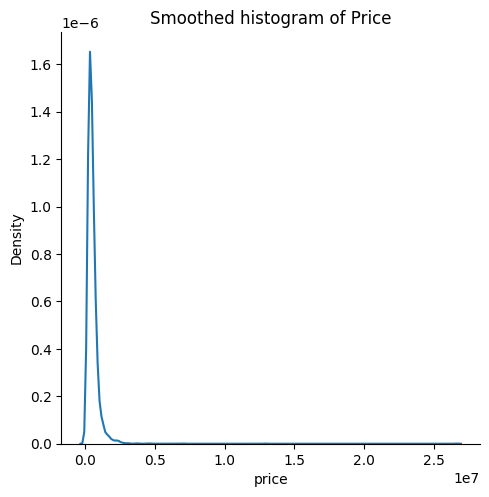

In [39]:
# Smoothed histogram of the outcome variable, price
sns.displot(data=data, x='price', kind='kde')
plt.title('Smoothed histogram of Price')
plt.show()

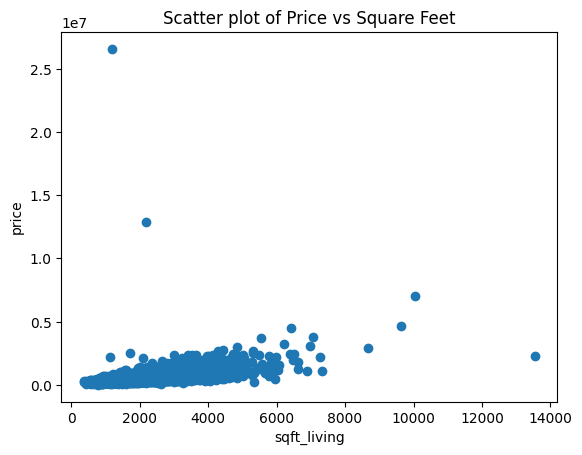

In [40]:
plt.scatter(data['sqft_living'], data['price'])
plt.xlabel('sqft_living')
plt.ylabel('price')
plt.title('Scatter plot of Price vs Square Feet')
plt.show()

There are two observations that are probably worth another look. Also recall that there was at least one very low price from the summary statistics. Let's look at both.

In [41]:
# Let's find the observations with very low prices and see what they look like
data[data['price'] < 50000]

,date,price,bathrooms,bedrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
3215,2014-05-06,7800.0,1.0,2,780,16344,1.0,0,0,1,780,0,1942,0,4229 S 144th St,Tukwila,WA 98168,USA


It seems a bit out of the realm of possibility to have a $7800 dollar property in the Seattle area in 2014, though the property seems not particularly desirable. I'm going to assume that the price here is incorrect.

In [42]:
# Let's find the observations with very high prices and see what they look like
data[data['price'] > 5000000]


,date,price,bathrooms,bedrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
1693,2014-06-11,7062500.0,4.5,5,10040,37325,2.0,1,2,3,7680,2360,1940,2001,4442 95th Ave NE,Bellevue,WA 98004,USA
3211,2014-06-23,12899000.0,2.5,3,2190,11394,1.0,0,0,3,1550,640,1956,2001,5426 40th Ave W,Seattle,WA 98199,USA
3214,2014-07-03,26590000.0,2.0,3,1180,7793,1.0,0,0,4,1180,0,1992,0,12005 SE 219th Ct,Kent,WA 98031,USA


I can believe that a 10000 square foot property sold for $7M.

I have a hard time believing a 2 bathroom, 3 bedroom, 1180 square foot property sold for ~\$27M. This seems like a mistake. I'm also having a hard time believing that a 2.5 bathroom, 3 bedroom, 2190 square foot property sold for ~$13M.

I am going to treat both of these observations as "mistakes" and drop them from my data. I am going to recognize that if these are real observations, there is a small chance I will see future properties that I make GIGANTIC mistakes on.

We can/should also run the whole thing with the dropped observations included to gauge robustness.

Finally, we could just use an evaluation metric that is robust to a couple outliers like the **median absolute deviation**.

In [44]:
# Drop the flagged observations
data = data.drop(data[data['price'] < 50000].index)
data = data.drop(data[data['price'] > 10000000].index)

Our price variable is highly skewed. It is very commeon to see data-scientists build models a right-skewed variable that only takes on positive values by taking a `log` transformation first. I.e. instead by building a model for `price`, we might instead build a model for `log(price)`.

**Remember that our goal is to predict `price` though!** Make sure you validate on the basis of what you care about.

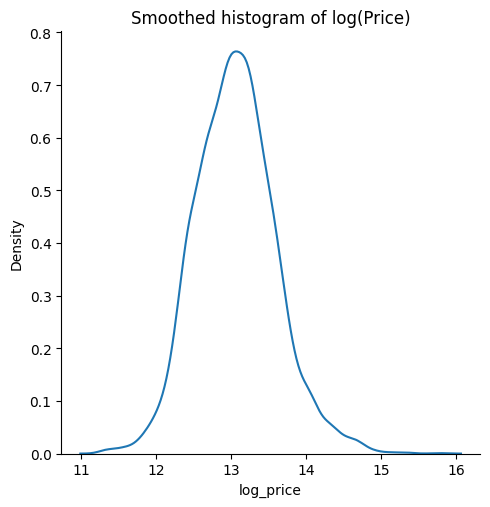

In [45]:
# Create new column with the log of price
data['log_price'] = np.log(data['price'])

# Smoothed histogram of log price
sns.displot(data=data, x='log_price', kind='kde')
plt.title('Smoothed histogram of log(Price)')
plt.show()

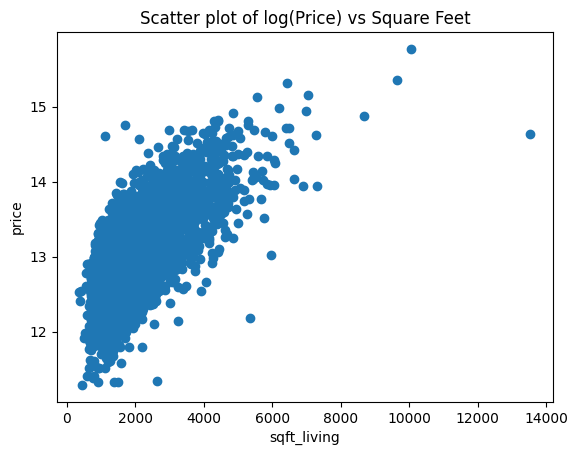

In [46]:
plt.scatter(data['sqft_living'], data['log_price'])
plt.xlabel('sqft_living')
plt.ylabel('price')
plt.title('Scatter plot of log(Price) vs Square Feet')
plt.show()

**Categorical Variables**

The four variables of type "object" are not numeric but coded as text. Let's look at what they are. In the following code blocks, we are just going to tabulate each of our categorical variables by looking at the `value_counts` property of our data.

In [47]:
data['street'].value_counts()

street
2520 Mulberry Walk NE      4
2500 Mulberry Walk NE      3
34214 SE Carmichael St     2
9126 45th Ave SW           2
7490 85th Ave SE           2
                          ..
11240 106th Ave NE         1
15530-15998 61st Ave NE    1
1622 38th Ave E            1
31229 NE 111th St          1
5148 S Creston St          1
Name: count, Length: 4471, dtype: int64

Most street addresses have only one property. Without better geographic knowledge, it's going to be hard to use this variable.

**Question:** If you really cared, how could you use the street address to get something potentially more useful? (Think about, e.g., google street view, google maps and routing, ...)

In [48]:
data['city'].value_counts()

city
Seattle                1559
Renton                  291
Bellevue                281
Redmond                 234
Kirkland                187
Issaquah                186
Kent                    183
Auburn                  175
Sammamish               171
Federal Way             145
Shoreline               123
Woodinville             114
Maple Valley             95
Mercer Island            82
Burien                   72
Snoqualmie               69
Kenmore                  65
Des Moines               58
North Bend               50
Duvall                   42
Covington                42
Lake Forest Park         34
Bothell                  33
Newcastle                33
Vashon                   29
SeaTac                   28
Tukwila                  28
Enumclaw                 27
Carnation                22
Normandy Park            17
Fall City                11
Medina                   11
Clyde Hill                9
Black Diamond             8
Ravensdale                7
Pacific        

City might be useful, but it is very unbalanced.

**Questions:**

1. Do we think the actual name of the city matters? Why might the variable `city` contain useful information?

2. If we want to predict something outside of the Seattle area, is the variable `city` useful? Could we make it useful with some more effort?

In [49]:
data['statezip'].value_counts()

statezip
WA 98103    148
WA 98052    135
WA 98117    132
WA 98115    129
WA 98006    109
           ... 
WA 98047      6
WA 98288      3
WA 98354      2
WA 98050      2
WA 98068      1
Name: count, Length: 77, dtype: int64

Zip code (`statezip`) seems like it might have more *interesting* variation than `city`.

**Questions:**

1. Do we think the actual numeric value of a property's zip code matters? Why might the variable `statezip` contain useful information?

2. If we want to predict something outside of the Seattle area, is the variable `statezip` useful? Could we make it useful with some more effort?

In [50]:
data['country'].value_counts()

country
USA    4546
Name: count, dtype: int64

Can't use the variable `country` - It doesn't *vary* 🙂.

**Aside: Categorical Variables.**

The typical way to use (unordered) categorical variables is to encode them as dummy variables/binary variables/use one-hot-encoding --  all of which are jargon for making a new set of variables that are 0 or 1 with 1 indicating the observation belongs to a category and 0 indicates it does not.

For example, if we had a variable `color` with two categories "red" and "blue", we just create two new variables `red` and `blue` where variable `red` = 1 for all observations that are red (and 0 otherwise) and `blue` is defined similarly. (Note: For standard linear models, you typically exclude one of the dummy variables. In our toy example, we don't need both the variables `red` and `blue` because if `red` = 1 we know `blue` = 0 and viceversa. That is, they have the same information.)

We'll look at doing this in our price example when we consider including `city` and `statezip` in our model.

Before doing anything else, let's drop the variables we definitely won't use.

In [51]:
data = data.drop(columns=['date','street','country'])

Finally, we also see that we have many other variables that are effectively capturing qualitative information or a mix. E.g. `bathrooms`, `bedrooms`, `floors`, `waterfront`, `view`, and `condition` might be thought of as categorical.

Let's look at these variables more carefully.

In [52]:
print(data['bathrooms'].value_counts())
print('\n')
print(data['bedrooms'].value_counts())
print('\n')
print(data['floors'].value_counts())
print('\n')
print(data['waterfront'].value_counts())
print('\n')
print(data['view'].value_counts())
print('\n')
print(data['condition'].value_counts())

bathrooms
2.50    1183
1.00     735
1.75     628
2.00     424
2.25     413
1.50     287
2.75     270
3.00     164
3.50     159
3.25     135
3.75      34
4.50      26
4.25      22
4.00      21
0.75      17
4.75       7
5.00       5
5.25       4
5.50       4
1.25       3
8.00       1
5.75       1
6.50       1
6.25       1
6.75       1
Name: count, dtype: int64


bedrooms
3    2023
4    1512
2     560
5     338
6      59
1      37
7      14
8       2
9       1
Name: count, dtype: int64


floors
1.0    2148
2.0    1790
1.5     439
3.0     127
2.5      41
3.5       1
Name: count, dtype: int64


waterfront
0    4516
1      30
Name: count, dtype: int64


view
0    4099
2     200
3     115
1      69
4      63
Name: count, dtype: int64


condition
3    2848
4    1237
5     425
2      31
1       5
Name: count, dtype: int64


Importantly, these variables all have an order to them. `bathrooms`, `bedrooms`, and `floors` also (arguably) have cardinal value. `view` and `condition` are clearly qualitative, but do have ordinal meaning. `waterfront` is already a dummy variable.

We could treat these by including them as dummy variables, but it also makes sense to use them as is (which is what we are going to do). Many ML procedures will happily and appropriately deal with ordered categorical features and numeric features with few values.

**Mixed variables**

The variables `sqft_basement` and `yr_renovated` have a 0 category indicating "no basement" or "never renovated" respectively.

We can add variables indicating the qualitative information. For many learners, adding this variable is also unnecessary.

In [53]:
# Add a variable for being renovated
data['renovated_flag'] = np.where(data['yr_renovated'] == 0, 0, 1)

# Add a variable for having a basement
data['basement_flag'] = np.where(data['sqft_basement'] == 0, 0, 1)

Do the the square footage variables `sqft_living`, `sqft_above` and `sqft_basement` capture different information?

In [57]:
# Let's calculate the correlation of sqft_living with sqft_above+sqft_basement
print('Correlation of sqft_living with (sqft_above+sqft_basement):',
      data['sqft_living'].corr(data['sqft_above']+data['sqft_basement']))

# Let's calculate the correlation with each element instead
print('Correlation of sqft_living with sqft_above:',
      data['sqft_living'].corr(data['sqft_above']))
print('Correlation of sqft_living with sqft_basement:',
      data['sqft_living'].corr(data['sqft_basement']))


Correlation of sqft_living with (sqft_above+sqft_basement): 1.0
Correlation of sqft_living with sqft_above: 0.8753741763754805
Correlation of sqft_living with sqft_basement: 0.45056175913347857


Cannot use `sqft_living` and both `sqft_basement` and `sqft_above` in the same linear model estimated by least squares (or least absolute values).

**Question:** How do we choose which to use?

## Prepare the data. Think about the model

For black box machine learners that discover nonlinearity automatically, thinking about how to model nonlinearity and other transformations to make of our available variables is not a big issue. The ability to put less time into  thinking about these issues is a major plus for ML algorithms. **You should always be thoughtful about variables in a model though.**

For learners like linear regression, thinking about the appropriate way to include variables is potentially very important though.


**Nonlinearity**

What about potential nonlinearities? For example, do we think that each unit increase in house's square footage at fixed values of other variables should be associated with the same change in predicted (log) price regardless of the square footage? E.g. do we think going from 1000 to 1100 square feet is the same "value" as going from 3000-3100 square feet? Do we think the "value" of going from 2000-2100 square feet is the same if we are talking about a three versus five bedroom property?

A very simple and interpretable way to allow for nonlinearities is to use *polynomials* and *interactions*. E.g. we might include `sqft_living` and `sqft_living`$^2$ to allow for decreasing or increasing "returns" to square footage in our model, so our prediction rule would be

$$\widehat{\texttt{log_price}} = b_0 + b_1 \texttt{sqft_living} + b_2 \texttt{sqft_living}^2 + ...$$

[Note that you cannot interpret $b_1$ and $b_2$ in isolation.]

We might also include the *interaction* `sqft_living`*`bedrooms` to allow the predicted price change for a given change in `sqft_living` to be different for properties with different numbers of bedrooms. In this case, our model would be

$$ \widehat{\texttt{log_price}} = b_0 + b_1 \texttt{sqft_living} + b_2 \texttt{sqft_living}^2 + b_3\texttt{bedrooms} + b_4 \texttt{sqft_living}*\texttt{bedrooms} + ...$$

[Note that you cannot interpret $b_1$, $b_2$, $b_3$, and $b_4$ in isolation.]

We will introduce a bunch of terms to allow for nonlinearities in our prediction rule.

Finally, let's set up our splits so we can evaluate our candidate models using cross-validation.

In [ ]:
cvsplit = KFold(n_splits=5, shuffle=True, random_state=rng)

In addition, we are going to fit models with `log_price` and with `price` as outcomes.

When we fit a model for `log_price`, we are still going to evaluate how well the model does for predicting `price`. To do this, we are going to take our prediction for `log_price` and exponentiate it to use as a prediction for `price`. This approach for predicting `price` from a model for `log_price` is formally wrong when using the if our target is to use the mean of price as the prediction rule. (Look up Jensen's inequality.) It is easy and works ok though and is basically approximating using the median under a symmetry assumption on log_price.

In order for this to work, we need to define a new evaluation metric.

In [ ]:
def expmse(y_true, y_pred):

  y_true = y_true.to_numpy()
  negmse = -np.mean((np.exp(y_true) - np.exp(y_pred))**2)

  return negmse

# Create a scorer object using the expmse function
expmse_score = make_scorer(expmse)

def expmae(y_true, y_pred):

  y_true = y_true.to_numpy()
  negmae = -np.mean(np.abs(np.exp(y_true) - np.exp(y_pred)))

  return negmae

# Create a scorer object using the expmae function
expmae_score = make_scorer(expmae)


# Baseline start

As simple benchmark, let's look at sample means and medians.


In [ ]:
# Define function to use mean as estimator and make prediction
class MeanEstimator(BaseEstimator, RegressorMixin):
    def fit(self, X, y=None):
        # Compute the mean of y during fitting
        self.mean_ = np.mean(y)
        return self

    def predict(self, X):
        # Return the mean for all predictions
        return np.full(len(X), self.mean_)

# Define function to use median as estimator and make prediction
class MedianEstimator(BaseEstimator, RegressorMixin):
    def fit(self, X, y=None):
        # Compute the mean of y during fitting
        self.median_ = np.median(y)
        return self

    def predict(self, X):
        # Return the mean for all predictions
        return np.full(len(X), self.median_)


In [ ]:
# Cross validation RMSE and MAE using sample mean of price as prediction rule
levmean_mse = cross_validate(MeanEstimator(), data['price'], data['price'], scoring=('neg_mean_squared_error','neg_mean_absolute_error'), cv=cvsplit)
print('Level Mean: CV RMSE: {m1:=.2f}; CV MAE: {m2:=.2f}'
  .format(m1=np.sqrt(-levmean_mse['test_neg_mean_squared_error'].mean()),
          m2=-levmean_mse['test_neg_mean_absolute_error'].mean()))

# Cross validation RMSE and MAE using sample median of price as prediction rule
levmedian_mse = cross_validate(MedianEstimator(), data['price'], data['price'], scoring=('neg_mean_squared_error','neg_mean_absolute_error'), cv=cvsplit)
print('Level Median: CV RMSE: {m1:=.2f}; CV MAE: {m2:=.2f}'
  .format(m1=np.sqrt(-levmedian_mse['test_neg_mean_squared_error'].mean()),
          m2=-levmedian_mse['test_neg_mean_absolute_error'].mean()))

# Set things up for custom scoring when using log(price)
scoring = {'expmse': expmse_score,
           'expmae': expmae_score}

# Cross validation RMSE and MAE using exp(sample mean of log price) as prediction rule
logmean_mse = cross_validate(MeanEstimator(), data['log_price'], data['log_price'], scoring=scoring, cv=cvsplit)
print('Log Mean: CV RMSE: {m1:=.2f}; CV MAE: {m2:=.2f}'
  .format(m1=np.sqrt(-logmean_mse['test_expmse'].mean()),
          m2=-logmean_mse['test_expmae'].mean()))

# Cross validation RMSE and MAE using exp(sample median of log price) as prediction rule
logmedian_mse = cross_validate(MedianEstimator(), data['log_price'], data['log_price'], scoring=scoring, cv=cvsplit)
print('Log Median: CV RMSE: {m1:=.2f}; CV MAE: {m2:=.2f}'
  .format(m1=np.sqrt(-logmedian_mse['test_expmse'].mean()),
          m2=-logmedian_mse['test_expmae'].mean()))



Level Mean: CV RMSE: 368394.52; CV MAE: 236991.21
Level Median: CV RMSE: 377846.60; CV MAE: 226256.31
Log Mean: CV RMSE: 376465.14; CV MAE: 226291.16
Log Median: CV RMSE: 377846.60; CV MAE: 226256.31


In [ ]:
# Let's create a table to keep track of results
model_results = pd.DataFrame()
model_results['Model'] = ['Level Mean', 'Level Median', 'Log Mean', 'Log Median']
model_results['RMSE'] = [np.sqrt(-levmean_mse['test_neg_mean_squared_error'].mean()),
                         np.sqrt(-levmedian_mse['test_neg_mean_squared_error'].mean()),
                         np.sqrt(-logmean_mse['test_expmse'].mean()),
                         np.sqrt(-logmedian_mse['test_expmse'].mean())]
model_results['R2 - MSE'] = ['-','-','-','-']
model_results['MAE'] = [-levmean_mse['test_neg_mean_absolute_error'].mean(),
                        -levmedian_mse['test_neg_mean_absolute_error'].mean(),
                        -logmean_mse['test_expmae'].mean(),
                        -logmedian_mse['test_expmae'].mean()]
model_results['R2 - MAE'] = ['-','-','-','-']
model_results['p'] = ['-','-','-','-']
model_results['p_use'] = ['-','-','-','-']
model_results

,Model,RMSE,R2 - MSE,MAE,R2 - MAE,p,p_use
0,Level Mean,368394.523654,-,236991.205826,-,-,-
1,Level Median,377846.602766,-,226256.310785,-,-,-
2,Log Mean,376465.140810,-,226291.159996,-,-,-
3,Log Median,377846.602766,-,226256.310785,-,-,-


From here on, we'll look at $R^2$ and pseudo-$R^2$ benchmarking to MSE from mean computed from `price` and to MAE from median computed from `price`.

In [ ]:
benchMSE = -levmean_mse['test_neg_mean_squared_error'].mean()
benchMAE = -levmedian_mse['test_neg_mean_absolute_error'].mean()

## Linear Models

Let's try some linear models out in a validation exercise. We'll try a couple of simple baseline models out and then try some elaborate models that try to capture nonlinearities.

# Linear Models via OLS


## Baseline model: City

Here we're just going to include all variables linearly and include dummy variables for `city`. We will exclude `statezip`.

In [ ]:
# Here, we're using the "formula" interface we imported from formulaic

# Specify model as formula
# Putting a variable inside "C" will make the variable be treated as categorical
# by turning it into dummy variables
city_base = ("price ~ bathrooms + bedrooms + sqft_living + sqft_lot + floors "
            "+ waterfront + view + condition + sqft_above + sqft_basement + "
            "yr_built + yr_renovated + C(city) + C(renovated_flag) + C(basement_flag)")

# Create variables based on model defined in formula
y, X = model_matrix(city_base, data)
n, p_base = X.shape

# Cross validation. We're just going to look at MSE from here on out
levlm = cross_validate(LinearRegression(), X, y,
                       scoring = ('neg_mean_squared_error','neg_mean_absolute_error'), cv=cvsplit)
print('Level Baseline LM: CV RMSE: {m1:=.2f}; CV R2: {m2:=.3f}; p: {m3:=.0f}'
  .format(m1=np.sqrt(-levlm['test_neg_mean_squared_error'].mean()),
          m2=1-(-levlm['test_neg_mean_squared_error'].mean()/benchMSE),
          m3=p_base))

print('Level Baseline LM: CV MAE: {m1:=.2f}; CV MAE R2: {m2:=.3f}; p: {m3:=.0f}'
  .format(m1=-levlm['test_neg_mean_absolute_error'].mean(),
          m2=1-(-levlm['test_neg_mean_absolute_error'].mean()/benchMAE),
          m3=p_base))


Level Baseline LM: CV RMSE: 210294.52; CV R2: 0.674; p: 58
Level Baseline LM: CV MAE: 122868.70; CV MAE R2: 0.457; p: 58


In [ ]:
# Let's add these results to our result table
model_results = model_results._append({'Model': 'Level Baseline LM',
                                     'RMSE': np.sqrt(-levlm['test_neg_mean_squared_error'].mean()),
                                     'R2 - MSE': 1-(-levlm['test_neg_mean_squared_error'].mean()/benchMSE),
                                     'MAE': -levlm['test_neg_mean_absolute_error'].mean(),
                                     'R2 - MAE': 1-(-levlm['test_neg_mean_absolute_error'].mean()/benchMAE),
                                     'p': p_base,
                                     'p_use': p_base}, ignore_index=True)
model_results

,Model,RMSE,R2 - MSE,MAE,R2 - MAE,p,p_use
0,Level Mean,368394.523654,-,236991.205826,-,-,-
1,Level Median,377846.602766,-,226256.310785,-,-,-
2,Log Mean,376465.140810,-,226291.159996,-,-,-
3,Log Median,377846.602766,-,226256.310785,-,-,-
4,Level Baseline LM,210294.521710,0.674141,122868.702578,0.456949,58,58


What does our linear model estimated on all the data look like?

In [ ]:
model = smf.ols(formula = city_base, data = data)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     190.6
Date:                Sun, 14 Jul 2024   Prob (F-statistic):               0.00
Time:                        19:43:42   Log-Likelihood:                -61989.
No. Observations:                4549   AIC:                         1.241e+05
Df Residuals:                    4492   BIC:                         1.245e+05
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Let's try the same predictor variables but use `log_price` as the target.

In [ ]:
# Specify model as formula
# Putting a variable inside "C" will make the variable be treated as categorical
# by turning it into dummy variables
city_base = ("log_price ~ bathrooms + bedrooms + sqft_living + sqft_lot + floors "
            "+ waterfront + view + condition + sqft_above + sqft_basement + "
            "yr_built + yr_renovated + C(city) + C(renovated_flag) + C(basement_flag)")

# Create variables based on model defined in formula
y, X = model_matrix(city_base, data)
n, p_base = X.shape

# Set things up for custom scoring when using log(price)
scoring = {'expmse': expmse_score,
           'expmae': expmae_score}

# Cross validation. We're just going to look at MSE from here on out
loglm = cross_validate(LinearRegression(), X, y, scoring=scoring, cv=cvsplit)
print('Log Baseline LM: CV RMSE: {m1:=.2f}; CV R2: {m2:=.3f}; p: {m3:=.0f}'
  .format(m1=np.sqrt(-loglm['test_expmse'].mean()),
          m2=1-(-loglm['test_expmse'].mean()/benchMSE),
          m3=p_base))

print('Log Baseline LM: CV MAE: {m1:=.2f}; CV MAE R2: {m2:=.3f}; p: {m3:=.0f}'
  .format(m1=-loglm['test_expmae'].mean(),
          m2=1-(-loglm['test_expmae'].mean()/benchMAE),
          m3=p_base))


Log Baseline LM: CV RMSE: 386717.72; CV R2: -0.102; p: 58
Log Baseline LM: CV MAE: 116778.95; CV MAE R2: 0.484; p: 58


In [ ]:
# Let's add these results to our result table
model_results = model_results._append({'Model': 'Log Baseline LM',
                                       'RMSE': np.sqrt(-loglm['test_expmse'].mean()),
                                       'R2 - MSE': 1-(-loglm['test_expmse'].mean()/benchMSE),
                                       'MAE': -loglm['test_expmae'].mean(),
                                       'R2 - MAE': 1-(-loglm['test_expmae'].mean()/benchMAE),
                                       'p': p_base,
                                       'p_use': p_base}, ignore_index=True)
model_results

,Model,RMSE,R2 - MSE,MAE,R2 - MAE,p,p_use
0,Level Mean,368394.523654,-,236991.205826,-,-,-
1,Level Median,377846.602766,-,226256.310785,-,-,-
2,Log Mean,376465.140810,-,226291.159996,-,-,-
3,Log Median,377846.602766,-,226256.310785,-,-,-
4,Level Baseline LM,210294.521710,0.674141,122868.702578,0.456949,58,58
5,Log Baseline LM,386717.720849,-0.10195,116778.946623,0.483864,58,58


What does this model for `log_price` look like on the full data?

In [ ]:
model = smf.ols(formula = city_base, data = data)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     226.9
Date:                Sun, 14 Jul 2024   Prob (F-statistic):               0.00
Time:                        19:43:44   Log-Likelihood:                -575.21
No. Observations:                4549   AIC:                             1264.
Df Residuals:                    4492   BIC:                             1631.
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

**Question:** Why don't we look at $R^2$ from this model? What does it tell us about our goal of predicting `price`?

# Baseline model: Zip code

Here, we're going to use `statezip` and drop `city`

In [ ]:
# Start with model for price
# Specify model as formula
# Putting a variable inside "C" will make the variable be treated as categorical
# by turning it into dummy variables
zip_base = ("price ~ bathrooms + bedrooms + sqft_living + sqft_lot + floors "
            "+ waterfront + view + condition + sqft_above + sqft_basement + "
            "yr_built + yr_renovated + C(statezip) + C(renovated_flag) + C(basement_flag)")

# Create variables based on model defined in formula
y, X = model_matrix(zip_base, data)
n, p_zip = X.shape

# Cross validation. We're just going to look at MSE from here on out
levZiplm = cross_validate(LinearRegression(), X, y,
                       scoring = ('neg_mean_squared_error','neg_mean_absolute_error'), cv=cvsplit)
print('Level Zip LM: CV RMSE: {m1:=.2f}; CV R2: {m2:=.3f}; p: {m3:=.0f}'
  .format(m1=np.sqrt(-levZiplm['test_neg_mean_squared_error'].mean()),
          m2=1-(-levZiplm['test_neg_mean_squared_error'].mean()/benchMSE),
          m3=p_zip))

print('Level Zip LM: CV MAE: {m1:=.2f}; CV MAE R2: {m2:=.3f}; p: {m3:=.0f}'
  .format(m1=-levZiplm['test_neg_mean_absolute_error'].mean(),
          m2=1-(-levZiplm['test_neg_mean_absolute_error'].mean()/benchMAE),
          m3=p_zip))

#####################################################################
# Model for log-price
zip_base = ("log_price ~ bathrooms + bedrooms + sqft_living + sqft_lot + floors "
            "+ waterfront + view + condition + sqft_above + sqft_basement + "
            "yr_built + yr_renovated + C(statezip) + C(renovated_flag) + C(basement_flag)")

# Create variables based on model defined in formula
y, X = model_matrix(zip_base, data)
n, p_zip = X.shape

# Set things up for custom scoring when using log(price)
scoring = {'expmse': expmse_score,
           'expmae': expmae_score}

# Cross validation. We're just going to look at MSE from here on out
logZiplm = cross_validate(LinearRegression(), X, y,
                       scoring = scoring, cv=cvsplit)
print('Log Zip LM: CV RMSE: {m1:=.2f}; CV R2: {m2:=.3f}; p: {m3:=.0f}'
  .format(m1=np.sqrt(-logZiplm['test_expmse'].mean()),
          m2=1-(-logZiplm['test_expmse'].mean()/benchMSE),
          m3=p_zip))

print('Log Zip LM: CV MAE: {m1:=.2f}; CV MAE R2: {m2:=.3f}; p: {m3:=.0f}'
  .format(m1=-logZiplm['test_expmae'].mean(),
          m2=1-(-logZiplm['test_expmae'].mean()/benchMAE),
          m3=p_zip))



Level Zip LM: CV RMSE: 186071.00; CV R2: 0.745; p: 91
Level Zip LM: CV MAE: 103853.99; CV MAE R2: 0.541; p: 91
Log Zip LM: CV RMSE: 303757.03; CV R2: 0.320; p: 91
Log Zip LM: CV MAE: 95335.28; CV MAE R2: 0.579; p: 91


In [ ]:
# Let's add these results to our result table
model_results = model_results._append({'Model': 'Level Zip LM',
                                       'RMSE': np.sqrt(-levZiplm['test_neg_mean_squared_error'].mean()),
                                       'R2 - MSE': 1-(-levZiplm['test_neg_mean_squared_error'].mean()/benchMSE),
                                       'MAE': -levZiplm['test_neg_mean_absolute_error'].mean(),
                                       'R2 - MAE': 1-(-levZiplm['test_neg_mean_absolute_error'].mean()/benchMAE),
                                       'p': p_zip,
                                       'p_use': p_zip}, ignore_index=True)

model_results = model_results._append({'Model': 'Log Zip LM',
                                       'RMSE': np.sqrt(-logZiplm['test_expmse'].mean()),
                                       'R2 - MSE': 1-(-logZiplm['test_expmse'].mean()/benchMSE),
                                       'MAE': -logZiplm['test_expmae'].mean(),
                                       'R2 - MAE': 1-(-logZiplm['test_expmae'].mean()/benchMAE),
                                       'p': p_zip,
                                       'p_use': p_zip}, ignore_index=True)

model_results

,Model,RMSE,R2 - MSE,MAE,R2 - MAE,p,p_use
0,Level Mean,368394.523654,-,236991.205826,-,-,-
1,Level Median,377846.602766,-,226256.310785,-,-,-
2,Log Mean,376465.140810,-,226291.159996,-,-,-
3,Log Median,377846.602766,-,226256.310785,-,-,-
4,Level Baseline LM,210294.521710,0.674141,122868.702578,0.456949,58,58
5,Log Baseline LM,386717.720849,-0.10195,116778.946623,0.483864,58,58
6,Level Zip LM,186070.995991,0.744888,103853.985257,0.54099,91,91
7,Log Zip LM,303757.027751,0.320129,95335.277089,0.57864,91,91


What if we try both zipcode and city?

In [ ]:
# Specify model as formula
# Putting a variable inside "C" will make the variable be treated as categorical
# by turning it into dummy variables
both_base = ("price ~ bathrooms + bedrooms + sqft_living + sqft_lot + floors "
            "+ waterfront + view + condition + sqft_above + sqft_basement + "
            "yr_built + yr_renovated + C(statezip) + C(renovated_flag) + C(basement_flag)"
            " + C(city)")

# Create variables based on model defined in formula
y, X = model_matrix(both_base, data)
n, p_both = X.shape

# Cross validation. We're just going to look at MSE from here on out
levbothlm = cross_validate(LinearRegression(), X, y,
                       scoring = ('neg_mean_squared_error','neg_mean_absolute_error'), cv=cvsplit)
print('Level Both LM: CV RMSE: {m1:=.2f}; CV R2: {m2:=.3f}; p: {m3:=.0f}'
  .format(m1=np.sqrt(-levbothlm['test_neg_mean_squared_error'].mean()),
          m2=1-(-levbothlm['test_neg_mean_squared_error'].mean()/benchMSE),
          m3=p_both))

print('Level Both LM: CV MAE: {m1:=.2f}; CV MAE R2: {m2:=.3f}; p: {m3:=.0f}'
  .format(m1=-levbothlm['test_neg_mean_absolute_error'].mean(),
          m2=1-(-levbothlm['test_neg_mean_absolute_error'].mean()/benchMAE),
          m3=p_both))

#####################################################################
# Model for log-price
both_base = ("log_price ~ bathrooms + bedrooms + sqft_living + sqft_lot + floors "
            "+ waterfront + view + condition + sqft_above + sqft_basement + "
            "yr_built + yr_renovated + C(statezip) + C(renovated_flag) + C(basement_flag)"
            " + C(city)")

# Create variables based on model defined in formula
y, X = model_matrix(both_base, data)
n, p_both = X.shape

# Set things up for custom scoring when using log(price)
scoring = {'expmse': expmse_score,
           'expmae': expmae_score}

# Cross validation. We're just going to look at MSE from here on out
logbothlm = cross_validate(LinearRegression(), X, y,
                       scoring = scoring, cv=cvsplit)
print('Log Both LM: CV RMSE: {m1:=.2f}; CV R2: {m2:=.3f}; p: {m3:=.0f}'
  .format(m1=np.sqrt(-logbothlm['test_expmse'].mean()),
          m2=1-(-logbothlm['test_expmse'].mean()/benchMSE),
          m3=p_both))

print('Log Both LM: CV MAE: {m1:=.2f}; CV MAE R2: {m2:=.3f}; p: {m3:=.0f}'
  .format(m1=-logbothlm['test_expmae'].mean(),
          m2=1-(-logbothlm['test_expmae'].mean()/benchMAE),
          m3=p_both))


Level Both LM: CV RMSE: 189945.72; CV R2: 0.734; p: 134
Level Both LM: CV MAE: 104027.54; CV MAE R2: 0.540; p: 134
Log Both LM: CV RMSE: 299659.93; CV R2: 0.338; p: 134
Log Both LM: CV MAE: 95159.79; CV MAE R2: 0.579; p: 134


In [ ]:
# Let's add these results to our result table
model_results = model_results._append({'Model': 'Level Both LM',
                                       'RMSE': np.sqrt(-levbothlm['test_neg_mean_squared_error'].mean()),
                                       'R2 - MSE': 1-(-levbothlm['test_neg_mean_squared_error'].mean()/benchMSE),
                                       'MAE': -levbothlm['test_neg_mean_absolute_error'].mean(),
                                       'R2 - MAE': 1-(-levbothlm['test_neg_mean_absolute_error'].mean()/benchMAE),
                                       'p': p_both,
                                       'p_use': p_both}, ignore_index=True)

model_results = model_results._append({'Model': 'Log Both LM',
                                       'RMSE': np.sqrt(-logbothlm['test_expmse'].mean()),
                                       'R2 - MSE': 1-(-logbothlm['test_expmse'].mean()/benchMSE),
                                       'MAE': -logbothlm['test_expmae'].mean(),
                                       'R2 - MAE': 1-(-logbothlm['test_expmae'].mean()/benchMAE),
                                       'p': p_both,
                                       'p_use': p_both}, ignore_index=True)

model_results


,Model,RMSE,R2 - MSE,MAE,R2 - MAE,p,p_use
0,Level Mean,368394.523654,-,236991.205826,-,-,-
1,Level Median,377846.602766,-,226256.310785,-,-,-
2,Log Mean,376465.140810,-,226291.159996,-,-,-
3,Log Median,377846.602766,-,226256.310785,-,-,-
4,Level Baseline LM,210294.521710,0.674141,122868.702578,0.456949,58,58
5,Log Baseline LM,386717.720849,-0.10195,116778.946623,0.483864,58,58
6,Level Zip LM,186070.995991,0.744888,103853.985257,0.54099,91,91
7,Log Zip LM,303757.027751,0.320129,95335.277089,0.57864,91,91
8,Level Both LM,189945.721982,0.734152,104027.536868,0.540223,134,134
9,Log Both LM,299659.927736,0.338346,95159.791725,0.579416,134,134


# Thinking about nonlinearity

Let's try a model that allows all of our continuous variables to enter quadratically. We're just going to use `statezip` and drop `city`.

In [ ]:
# Specify model as formula
# Putting a variable inside "C" will make the variable be treated as categorical
# by turning it into dummy variables
# Putting a variable inside "poly" will a create a polynomial in that variable
poly_base = ("price ~ poly(bathrooms, degree=2, raw=True) + poly(bedrooms, degree=2, raw=True)"
             " + poly(sqft_living, degree=2, raw=True) + poly(sqft_lot, degree=2, raw=True) + poly(floors, degree=2, raw=True) "
            "+ waterfront + poly(view, degree=2, raw=True) + poly(condition, degree=2, raw=True)"
            " + poly(sqft_above, degree=2, raw=True) + poly(sqft_basement, degree=2, raw=True) + "
            "poly(yr_built, degree=2, raw=True) + poly(yr_renovated, degree=2, raw=True) + C(statezip) + C(renovated_flag) + C(basement_flag)")

# Create variables based on model defined in formula
y, X = model_matrix(poly_base, data)
n, p_poly = X.shape

# Cross validation. We're just going to look at MSE from here on out
levpolylm = cross_validate(LinearRegression(), X, y,
                       scoring = ('neg_mean_squared_error','neg_mean_absolute_error'), cv=cvsplit)
print('Level poly LM: CV RMSE: {m1:=.2f}; CV R2: {m2:=.3f}; p: {m3:=.0f}'
  .format(m1=np.sqrt(-levpolylm['test_neg_mean_squared_error'].mean()),
          m2=1-(-levpolylm['test_neg_mean_squared_error'].mean()/benchMSE),
          m3=p_poly))

print('Level poly LM: CV MAE: {m1:=.2f}; CV MAE R2: {m2:=.3f}; p: {m3:=.0f}'
  .format(m1=-levpolylm['test_neg_mean_absolute_error'].mean(),
          m2=1-(-levpolylm['test_neg_mean_absolute_error'].mean()/benchMAE),
          m3=p_poly))

#####################################################################
# Model for log-price
poly_base = ("log_price ~ poly(bathrooms, degree=2, raw=True) + poly(bedrooms, degree=2, raw=True)"
             " + poly(sqft_living, degree=2, raw=True) + poly(sqft_lot, degree=2, raw=True) + poly(floors, degree=2, raw=True) "
            "+ waterfront + poly(view, degree=2, raw=True) + poly(condition, degree=2, raw=True)"
            " + poly(sqft_above, degree=2, raw=True) + poly(sqft_basement, degree=2, raw=True) + "
            "poly(yr_built, degree=2, raw=True) + poly(yr_renovated, degree=2, raw=True) + C(statezip) + C(renovated_flag) + C(basement_flag)")

# Create variables based on model defined in formula
y, X = model_matrix(poly_base, data)
n, p_poly = X.shape

# Set things up for custom scoring when using log(price)
scoring = {'expmse': expmse_score,
           'expmae': expmae_score}

# Cross validation. We're just going to look at MSE from here on out
logpolylm = cross_validate(LinearRegression(), X, y,
                       scoring = scoring, cv=cvsplit)
print('Log poly LM: CV RMSE: {m1:=.2f}; CV R2: {m2:=.3f}; p: {m3:=.0f}'
  .format(m1=np.sqrt(-logpolylm['test_expmse'].mean()),
          m2=1-(-logpolylm['test_expmse'].mean()/benchMSE),
          m3=p_poly))

print('Log poly LM: CV MAE: {m1:=.2f}; CV MAE R2: {m2:=.3f}; p: {m3:=.0f}'
  .format(m1=-logpolylm['test_expmae'].mean(),
          m2=1-(-logpolylm['test_expmae'].mean()/benchMAE),
          m3=p_poly))


Level poly LM: CV RMSE: 199601.96; CV R2: 0.706; p: 102
Level poly LM: CV MAE: 101840.42; CV MAE R2: 0.550; p: 102
Log poly LM: CV RMSE: 168127.46; CV R2: 0.792; p: 102
Log poly LM: CV MAE: 87249.19; CV MAE R2: 0.614; p: 102


In [ ]:
# Let's add these results to our result table
model_results = model_results._append({'Model': 'Level poly LM',
                                       'RMSE': np.sqrt(-levpolylm['test_neg_mean_squared_error'].mean()),
                                       'R2 - MSE': 1-(-levpolylm['test_neg_mean_squared_error'].mean()/benchMSE),
                                       'MAE': -levpolylm['test_neg_mean_absolute_error'].mean(),
                                       'R2 - MAE': 1-(-levpolylm['test_neg_mean_absolute_error'].mean()/benchMAE),
                                       'p': p_poly,
                                       'p_use': p_poly}, ignore_index=True)

model_results = model_results._append({'Model': 'Log poly LM',
                                       'RMSE': np.sqrt(-logpolylm['test_expmse'].mean()),
                                       'R2 - MSE': 1-(-logpolylm['test_expmse'].mean()/benchMSE),
                                       'MAE': -logpolylm['test_expmae'].mean(),
                                       'R2 - MAE': 1-(-logpolylm['test_expmae'].mean()/benchMAE),
                                       'p': p_poly,
                                       'p_use': p_poly}, ignore_index=True)

model_results


,Model,RMSE,R2 - MSE,MAE,R2 - MAE,p,p_use
0,Level Mean,368394.523654,-,236991.205826,-,-,-
1,Level Median,377846.602766,-,226256.310785,-,-,-
2,Log Mean,376465.140810,-,226291.159996,-,-,-
3,Log Median,377846.602766,-,226256.310785,-,-,-
4,Level Baseline LM,210294.521710,0.674141,122868.702578,0.456949,58,58
5,Log Baseline LM,386717.720849,-0.10195,116778.946623,0.483864,58,58
6,Level Zip LM,186070.995991,0.744888,103853.985257,0.54099,91,91
7,Log Zip LM,303757.027751,0.320129,95335.277089,0.57864,91,91
8,Level Both LM,189945.721982,0.734152,104027.536868,0.540223,134,134
9,Log Both LM,299659.927736,0.338346,95159.791725,0.579416,134,134


What if we want to include interactions?

**(This block takes a few minutes to run.)**

In [ ]:
# Specify model as formula
# Putting a variable inside "C" will make the variable be treated as categorical
# by turning it into dummy variables
# Putting a variable inside "poly" will a create a polynomial in that variable
# Putting the **2 includes all interactions of all variables inside parentheses
int_base = ("price ~ (poly(bathrooms, degree=2, raw=True) + poly(bedrooms, degree=2, raw=True)"
             " + poly(sqft_living, degree=2, raw=True) + poly(sqft_lot, degree=2, raw=True) + poly(floors, degree=2, raw=True) "
            "+ waterfront + poly(view, degree=2, raw=True) + poly(condition, degree=2, raw=True)"
            " + poly(sqft_above, degree=2, raw=True) + poly(sqft_basement, degree=2, raw=True) + "
            "poly(yr_built, degree=2, raw=True) + poly(yr_renovated, degree=2, raw=True) + C(statezip) + C(renovated_flag) + C(basement_flag))**2")

# Create variables based on model defined in formula
y, X = model_matrix(int_base, data)
n, p_int = X.shape

# Cross validation. We're just going to look at MSE from here on out
levintlm = cross_validate(LinearRegression(), X, y,
                       scoring = ('neg_mean_squared_error','neg_mean_absolute_error'), cv=cvsplit)
print('Level int LM: CV RMSE: {m1:=.2f}; CV R2: {m2:=.3f}; p: {m3:=.0f}'
  .format(m1=np.sqrt(-levintlm['test_neg_mean_squared_error'].mean()),
          m2=1-(-levintlm['test_neg_mean_squared_error'].mean()/benchMSE),
          m3=p_int))

print('Level int LM: CV MAE: {m1:=.2f}; CV MAE R2: {m2:=.3f}; p: {m3:=.0f}'
  .format(m1=-levintlm['test_neg_mean_absolute_error'].mean(),
          m2=1-(-levintlm['test_neg_mean_absolute_error'].mean()/benchMAE),
          m3=p_int))

#####################################################################
# Model for log-price
int_base = ("log_price ~ (poly(bathrooms, degree=2, raw=True) + poly(bedrooms, degree=2, raw=True)"
             " + poly(sqft_living, degree=2, raw=True) + poly(sqft_lot, degree=2, raw=True) + poly(floors, degree=2, raw=True) "
            "+ waterfront + poly(view, degree=2, raw=True) + poly(condition, degree=2, raw=True)"
            " + poly(sqft_above, degree=2, raw=True) + poly(sqft_basement, degree=2, raw=True) + "
            "poly(yr_built, degree=2, raw=True) + poly(yr_renovated, degree=2, raw=True) + C(statezip) + C(renovated_flag) + C(basement_flag))**2")

# Create variables based on model defined in formula
y, X = model_matrix(int_base, data)
n, p_int = X.shape

# Set things up for custom scoring when using log(price)
scoring = {'expmse': expmse_score,
           'expmae': expmae_score}

# Cross validation. We're just going to look at MSE from here on out
logintlm = cross_validate(LinearRegression(), X, y,
                       scoring = scoring, cv=cvsplit)
print('Log int LM: CV RMSE: {m1:=.2f}; CV R2: {m2:=.3f}; p: {m3:=.0f}'
  .format(m1=np.sqrt(-logintlm['test_expmse'].mean()),
          m2=1-(-logintlm['test_expmse'].mean()/benchMSE),
          m3=p_int))

print('Log int LM: CV MAE: {m1:=.2f}; CV MAE R2: {m2:=.3f}; p: {m3:=.0f}'
  .format(m1=-logintlm['test_expmae'].mean(),
          m2=1-(-logintlm['test_expmae'].mean()/benchMAE),
          m3=p_int))



Level int LM: CV RMSE: 1048966.67; CV R2: -7.108; p: 2291
Level int LM: CV MAE: 168306.58; CV MAE R2: 0.256; p: 2291
Log int LM: CV RMSE: 217304507935374890177705429560944243046145958736982920018609695593236269750680597119169712353181696.00; CV R2: -347945432877496647239604844964229201365992029382469454342572422521953467874475108560653306749556213837804278980018546028085344728222315060993533664021108990777009321545694826246386483200.000; p: 2291
Log int LM: CV MAE: 3221536360289469386495079773077267879808300996076774122427749965250871320235120494492293936447488.00; CV MAE R2: -14238437589289875184215017539793794920215881912592104919231572616065464844667080643079831552.000; p: 2291


In [ ]:
# Let's add these results to our result table
model_results = model_results._append({'Model': 'Level int LM',
                                       'RMSE': np.sqrt(-levintlm['test_neg_mean_squared_error'].mean()),
                                       'R2 - MSE': 1-(-levintlm['test_neg_mean_squared_error'].mean()/benchMSE),
                                       'MAE': -levintlm['test_neg_mean_absolute_error'].mean(),
                                       'R2 - MAE': 1-(-levintlm['test_neg_mean_absolute_error'].mean()/benchMAE),
                                       'p': p_int,
                                       'p_use': p_int}, ignore_index=True)

model_results = model_results._append({'Model': 'Log int LM',
                                       'RMSE': np.sqrt(-logintlm['test_expmse'].mean()),
                                       'R2 - MSE': 1-(-logintlm['test_expmse'].mean()/benchMSE),
                                       'MAE': -logintlm['test_expmae'].mean(),
                                       'R2 - MAE': 1-(-logintlm['test_expmae'].mean()/benchMAE),
                                       'p': p_int,
                                       'p_use': p_int}, ignore_index=True)

model_results


,Model,RMSE,R2 - MSE,MAE,R2 - MAE,p,p_use
0,Level Mean,3.683945e+05,-,2.369912e+05,-,-,-
1,Level Median,3.778466e+05,-,2.262563e+05,-,-,-
2,Log Mean,3.764651e+05,-,2.262912e+05,-,-,-
3,Log Median,3.778466e+05,-,2.262563e+05,-,-,-
4,Level Baseline LM,2.102945e+05,0.674141,1.228687e+05,0.456949,58,58
5,Log Baseline LM,3.867177e+05,-0.10195,1.167789e+05,0.483864,58,58
6,Level Zip LM,1.860710e+05,0.744888,1.038540e+05,0.54099,91,91
7,Log Zip LM,3.037570e+05,0.320129,9.533528e+04,0.57864,91,91
8,Level Both LM,1.899457e+05,0.734152,1.040275e+05,0.540223,134,134
9,Log Both LM,2.996599e+05,0.338346,9.515979e+04,0.579416,134,134


It looks like the model with interactions does a really bad job.

**Questions:**
1. I'm only showing validation sample performance measures. How do we think in-sample validation measures line up?
2. Does the very poor validation performance of the "interactions" model mean nothing in the model adds predictive power beyond the other models?
3. Are we sure we have tried everything we want? There are lots of "intermediate" models?
4. Should we have even more interactions or allow for higher order nonlinearity? How do we specify all the choices?

## Lasso

A popular approach to estimating linear models when there are many potential variables is the *Lasso*.

Recall that conventional linear model estimates are obtained by solving

$$\min \sum_{i} (y_i - b_0 - b_1 X_1 - ... - b_p X_p)^2$$

where the sum is over all observations in the training data. That is, we try to find the linear prediction rule for $Y$ that is as close as possible to $Y$ in the training data.

Lasso solves a similar problem

$$\min \sum_{i} (y_i - b_0 - b_1 X_1 - ... - b_p X_p)^2 + \lambda \sum_j |b_j|.$$

The key thing we have added is a *penalty term* $\lambda \sum_j |b_j|$. Intuitively, this penalty says that if you want to move a coefficient $b_j$ away from 0 to improve the in-sample fit, you also have to pay a cost introduced by the penalty term.

In practice, the presence of the penalty may lead to variables being excluded from the model. Intuitively, if the benefit of moving a $b_j$ away from 0 is smaller than the cost, the coefficient will be left at 0.

When we do Lasso, we have to choose the *tuning parameter* $\lambda$ which controls the cost of increasing the size of coefficients. We choose $\lambda$ by trying several values and choosing the best according to cross-validation (or just validation).

[Aside: There are MANY other penalized regression procedures. Another popular one is Ridge. There's also grouped Lasso, Elastic Net, ... The basic idea of all of them is to guard against overfitting by penalizing large values of coefficients. Not all of them do variable selection.]


Let's look at how Lasso does in our example. We have to start from a model that has the universe of variables that could matter. We'll start from both the polynomial and interactive models and see what happens.

# Lasso with "polynomial" model

First, look at model with `price` as dependent variable.

In [ ]:
poly_base = ("price ~ poly(bathrooms, degree=2, raw=True) + poly(bedrooms, degree=2, raw=True)"
             " + poly(sqft_living, degree=2, raw=True) + poly(sqft_lot, degree=2, raw=True) + poly(floors, degree=2, raw=True) "
            "+ waterfront + poly(view, degree=2, raw=True) + poly(condition, degree=2, raw=True)"
            " + poly(sqft_above, degree=2, raw=True) + poly(sqft_basement, degree=2, raw=True) + "
            "poly(yr_built, degree=2, raw=True) + poly(yr_renovated, degree=2, raw=True) + C(statezip) + C(renovated_flag) + C(basement_flag)"
            " + C(city)")

# Create variables based on model defined in formula
y, X = model_matrix(poly_base, data)
n, p_polylasso = X.shape

# Sequence of penalty parameters to try
ub = np.std(y)*np.sqrt(2*np.log(2*p_polylasso/.05))/np.sqrt(n)
lambdas = np.geomspace(start=ub/100, stop=ub, num=25)

# Let's do cross-validation in the training data to choose a value for lambda
model = make_pipeline(StandardScaler(), Lasso())
# "StandardScaler" is important here. It standardizes the data. Because Lasso
# depends on the coefficients of the linear model and the coefficients depend
# on the scale of the X's, you can get very different answers depending on how
# you choose to scale the variables.

# Cross validation
parameters = {'lasso__alpha':lambdas.ravel()}

laspoly = GridSearchCV(model, parameters,
                       scoring = ('neg_mean_squared_error','neg_mean_absolute_error'),
                       refit = 'neg_mean_squared_error', cv=cvsplit)
laspoly.fit(X, y)

# Extract the performance measures and find the values at the MSE minimizing
# value of the tuning parameter
# Could also look at MAE minimizing, but didn't do it here.
lranks = laspoly.cv_results_.get('rank_test_neg_mean_squared_error')
cvmse_laspoly = -laspoly.cv_results_.get('mean_test_neg_mean_squared_error')
cvmae_laspoly = -laspoly.cv_results_.get('mean_test_neg_mean_absolute_error')

bestmse_laspoly = cvmse_laspoly[lranks == 1].min()
bestmae_laspoly = cvmae_laspoly[lranks == 1].min()

# Let's see how many variables are lasso model is using
# Get the best model
best_model = laspoly.best_estimator_

# Access Lasso model from the pipeline
lasso_model = best_model.named_steps['lasso']

# Retrieve coefficients
coefficients = lasso_model.coef_
p_polylasso_use = sum(coefficients != 0)

# Print out summary of performance
print('Level Poly Lasso: CV RMSE: {m1:=.2f}; CV R2: {m2:=.3f}'
  .format(m1=np.sqrt(bestmse_laspoly),
          m2=1-(bestmse_laspoly/benchMSE)))

print('Level Poly Lasso: CV MAE: {m1:=.2f}; CV MAE R2: {m2:=.3f}'
  .format(m1=bestmae_laspoly,
          m2=1-(bestmae_laspoly/benchMAE)))

print("p_poly: ", p_polylasso)
print("p_polylasso_use: ", p_polylasso_use)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.786e+10, tolerance: 4.188e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.939e+10, tolerance: 5.156e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.424e+11, tolerance: 5.144e

Level Poly Lasso: CV RMSE: 197986.10; CV R2: 0.711
Level Poly Lasso: CV MAE: 100761.97; CV MAE R2: 0.555
p_poly:  145
p_polylasso_use:  95


In [ ]:
# Let's add these results to our result table
model_results = model_results._append({'Model': 'Level Poly Lasso',
                                       'RMSE': np.sqrt(bestmse_laspoly),
                                       'R2 - MSE': 1-(bestmse_laspoly/benchMSE),
                                       'MAE': bestmae_laspoly,
                                       'R2 - MAE': 1-(bestmae_laspoly/benchMAE),
                                       'p': p_polylasso,
                                       'p_use': p_polylasso_use}, ignore_index=True)

model_results

,Model,RMSE,R2 - MSE,MAE,R2 - MAE,p,p_use
0,Level Mean,3.683945e+05,-,2.369912e+05,-,-,-
1,Level Median,3.778466e+05,-,2.262563e+05,-,-,-
2,Log Mean,3.764651e+05,-,2.262912e+05,-,-,-
3,Log Median,3.778466e+05,-,2.262563e+05,-,-,-
4,Level Baseline LM,2.102945e+05,0.674141,1.228687e+05,0.456949,58,58
5,Log Baseline LM,3.867177e+05,-0.10195,1.167789e+05,0.483864,58,58
6,Level Zip LM,1.860710e+05,0.744888,1.038540e+05,0.54099,91,91
7,Log Zip LM,3.037570e+05,0.320129,9.533528e+04,0.57864,91,91
8,Level Both LM,1.899457e+05,0.734152,1.040275e+05,0.540223,134,134
9,Log Both LM,2.996599e+05,0.338346,9.515979e+04,0.579416,134,134


In [ ]:
# Which variables do we use
print(X.columns[lasso_model.coef_ != 0])

# Which do we drop
print(X.columns[lasso_model.coef_ == 0])


Index(['poly(bathrooms, degree=2, raw=True)[0]',
       'poly(bedrooms, degree=2, raw=True)[1]',
       'poly(sqft_living, degree=2, raw=True)[0]',
       'poly(sqft_living, degree=2, raw=True)[1]',
       'poly(sqft_lot, degree=2, raw=True)[0]',
       'poly(floors, degree=2, raw=True)[1]', 'waterfront',
       'poly(view, degree=2, raw=True)[0]',
       'poly(view, degree=2, raw=True)[1]',
       'poly(condition, degree=2, raw=True)[1]',
       'poly(sqft_above, degree=2, raw=True)[0]',
       'poly(yr_built, degree=2, raw=True)[0]',
       'poly(yr_renovated, degree=2, raw=True)[1]', 'C(statezip)[T.WA 98004]',
       'C(statezip)[T.WA 98005]', 'C(statezip)[T.WA 98008]',
       'C(statezip)[T.WA 98014]', 'C(statezip)[T.WA 98019]',
       'C(statezip)[T.WA 98022]', 'C(statezip)[T.WA 98023]',
       'C(statezip)[T.WA 98029]', 'C(statezip)[T.WA 98032]',
       'C(statezip)[T.WA 98033]', 'C(statezip)[T.WA 98038]',
       'C(statezip)[T.WA 98039]', 'C(statezip)[T.WA 98040]',
       'C(sta

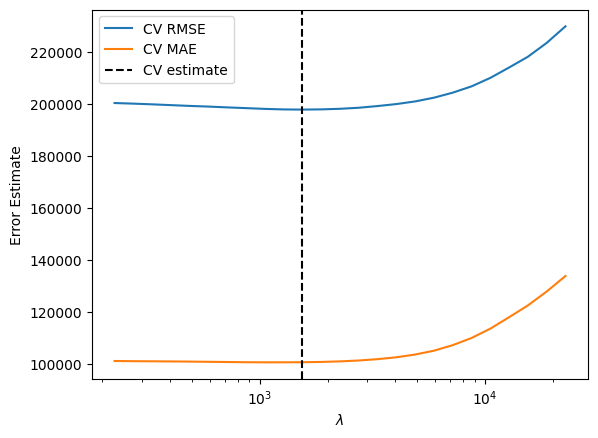

In [ ]:
# Plot the performance metrics across values of the tuning parameter
cvrmse_laspoly = np.sqrt(cvmse_laspoly)
lambdas = laspoly.cv_results_.get('param_lasso__alpha').tolist()

# Make plot
plt.semilogx(lambdas, cvrmse_laspoly, label='CV RMSE')
plt.semilogx(lambdas, cvmae_laspoly, label='CV MAE')
plt.axvline(laspoly.best_params_.get('lasso__alpha'),
            linestyle="--", color="black", label="CV estimate")
plt.xlabel(r"$\lambda$")
plt.ylabel("Error Estimate")
plt.legend()
plt.show()

Let's change and look at `log_price` as the dependent variable.

In [ ]:
poly_base = ("log_price ~ poly(bathrooms, degree=2, raw=True) + poly(bedrooms, degree=2, raw=True)"
             " + poly(sqft_living, degree=2, raw=True) + poly(sqft_lot, degree=2, raw=True) + poly(floors, degree=2, raw=True) "
            "+ waterfront + poly(view, degree=2, raw=True) + poly(condition, degree=2, raw=True)"
            " + poly(sqft_above, degree=2, raw=True) + poly(sqft_basement, degree=2, raw=True) + "
            "poly(yr_built, degree=2, raw=True) + poly(yr_renovated, degree=2, raw=True) + C(statezip) + C(renovated_flag) + C(basement_flag)"
            " + C(city)")

# Create variables based on model defined in formula
y, X = model_matrix(poly_base, data)
n, p_polylasso = X.shape

# Sequence of penalty parameters to try
ub = np.std(y)*np.sqrt(2*np.log(2*p_polylasso/.05))/np.sqrt(n)
lambdas = np.geomspace(start=ub/100, stop=ub, num=25)

# Let's do cross-validation in the training data to choose a value for lambda
model = make_pipeline(StandardScaler(), Lasso())
# "StandardScaler" is important here. It standardizes the data. Because Lasso
# depends on the coefficients of the linear model and the coefficients depend
# on the scale of the X's, you can get very different answers depending on how
# you choose to scale the variables.

# Cross validation
parameters = {'lasso__alpha':lambdas.ravel()}

# Set things up for custom scoring when using log(price)
scoring = {'expmse': expmse_score,
           'expmae': expmae_score,
           'mse': 'neg_mean_squared_error',
           'mae': 'neg_mean_absolute_error'}

loglaspoly = GridSearchCV(model, parameters,
                       scoring = scoring,
                       refit = 'mse', cv=cvsplit)

loglaspoly.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.809e-01, tolerance: 1.010e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.379e-01, tolerance: 1.058e-01
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=KFold(n_splits=5, random_state=713, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': array([0.00033165, 0.00040181, 0.0004868 , 0.00058977, 0.00071452,
       0.00086567, 0.00104878, 0.00127062, 0.0015394 , 0.00186502,
       0.00225953, 0.00273748, 0.00331653, 0.00401807, 0.004868  ,
       0.00589772, 0.00714525, 0.00865667, 0.01048779, 0.01270625,
       0.01539397, 0.01865022, 0.02259526, 0.02737478, 0.0331653 ])},
             refit='mse',
             scoring={'expmae': make_scorer(expmae),
                      'expmse': make_scorer(expmse),
                      'mae': 'neg_mean_absolute_error',
                      'mse': 'neg_mean_squared_error'})

In [ ]:
# Extract the performance measures and find the values at the MSE minimizing
# value of the tuning parameter
# Could also look at MAE minimizing, but didn't do it here.
lranks = loglaspoly.cv_results_.get('rank_test_mse')
cvlogmse_loglaspoly = -loglaspoly.cv_results_.get('mean_test_mse')
cvlogmae_loglaspoly = -loglaspoly.cv_results_.get('mean_test_mae')
cvmse_loglaspoly = -loglaspoly.cv_results_.get('mean_test_expmse')
cvmae_loglaspoly = -loglaspoly.cv_results_.get('mean_test_expmae')

bestmse_loglaspoly = cvmse_loglaspoly[lranks == 1].min()
bestmae_loglaspoly = cvmae_loglaspoly[lranks == 1].min()

# Let's see how many variables are lasso model is using
# Get the best model
best_model = loglaspoly.best_estimator_

# Access Lasso model from the pipeline
lasso_model = best_model.named_steps['lasso']

# Retrieve coefficients
coefficients = lasso_model.coef_
p_polyloglasso_use = sum(coefficients != 0)

# Print out summary of performance
print('Log Poly Lasso: CV RMSE: {m1:=.2f}; CV R2: {m2:=.3f}'
  .format(m1=np.sqrt(bestmse_loglaspoly),
          m2=1-(bestmse_loglaspoly/benchMSE)))

print('Log Poly Lasso: CV MAE: {m1:=.2f}; CV MAE R2: {m2:=.3f}'
  .format(m1=bestmae_loglaspoly,
          m2=1-(bestmae_loglaspoly/benchMAE)))

print("p_poly: ", p_polylasso)
print("p_polylasso_use: ", p_polyloglasso_use)

Log Poly Lasso: CV RMSE: 483800.09; CV R2: -0.725
Log Poly Lasso: CV MAE: 317848.38; CV MAE R2: -0.405
p_poly:  145
p_polylasso_use:  119


In [ ]:
# Let's add these results to our result table
model_results = model_results._append({'Model': 'Log Poly Lasso',
                                       'RMSE': np.sqrt(bestmse_loglaspoly),
                                       'R2 - MSE': 1-(bestmse_loglaspoly/benchMSE),
                                       'MAE': bestmae_loglaspoly,
                                       'R2 - MAE': 1-(bestmae_loglaspoly/benchMAE),
                                       'p': p_polylasso,
                                       'p_use': p_polyloglasso_use}, ignore_index=True)

model_results

,Model,RMSE,R2 - MSE,MAE,R2 - MAE,p,p_use
0,Level Mean,3.683945e+05,-,2.369912e+05,-,-,-
1,Level Median,3.778466e+05,-,2.262563e+05,-,-,-
2,Log Mean,3.764651e+05,-,2.262912e+05,-,-,-
3,Log Median,3.778466e+05,-,2.262563e+05,-,-,-
4,Level Baseline LM,2.102945e+05,0.674141,1.228687e+05,0.456949,58,58
5,Log Baseline LM,3.867177e+05,-0.10195,1.167789e+05,0.483864,58,58
6,Level Zip LM,1.860710e+05,0.744888,1.038540e+05,0.54099,91,91
7,Log Zip LM,3.037570e+05,0.320129,9.533528e+04,0.57864,91,91
8,Level Both LM,1.899457e+05,0.734152,1.040275e+05,0.540223,134,134
9,Log Both LM,2.996599e+05,0.338346,9.515979e+04,0.579416,134,134


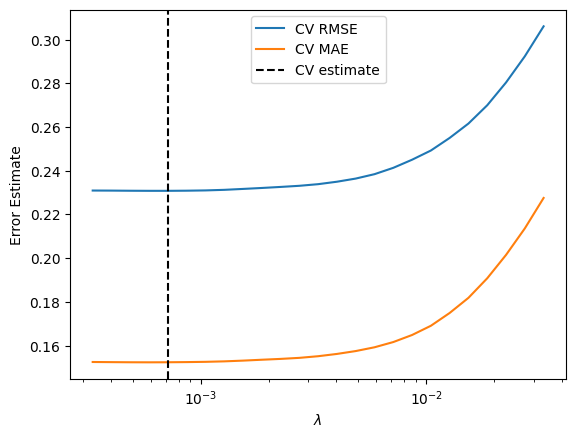

In [ ]:
# Plot the performance metrics across values of the tuning parameter
cvlogrmse_loglaspoly = np.sqrt(cvlogmse_loglaspoly)
lambdas = loglaspoly.cv_results_.get('param_lasso__alpha').tolist()

# Make plot
plt.semilogx(lambdas, cvlogrmse_loglaspoly, label='CV RMSE')
plt.semilogx(lambdas, cvlogmae_loglaspoly, label='CV MAE')
plt.axvline(loglaspoly.best_params_.get('lasso__alpha'),
            linestyle="--", color="black", label="CV estimate")
plt.xlabel(r"$\lambda$")
plt.ylabel("Error Estimate")
plt.legend()
plt.show()

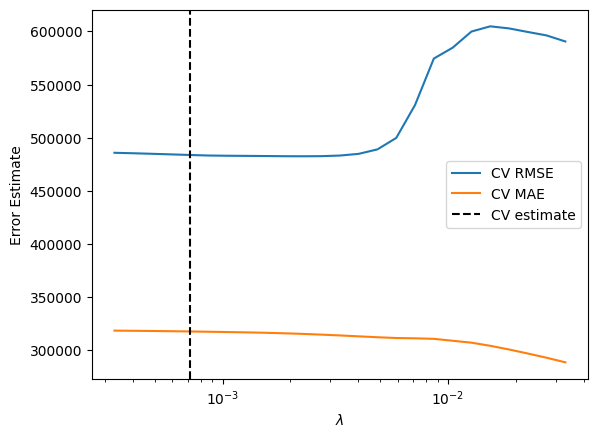

In [ ]:
# Plot the performance metrics for PRICE across values of the tuning parameter
cvrmse_loglaspoly = np.sqrt(cvmse_loglaspoly)
lambdas = loglaspoly.cv_results_.get('param_lasso__alpha').tolist()

# Make plot
plt.semilogx(lambdas, cvrmse_loglaspoly, label='CV RMSE')
plt.semilogx(lambdas, cvmae_loglaspoly, label='CV MAE')
plt.axvline(loglaspoly.best_params_.get('lasso__alpha'),
            linestyle="--", color="black", label="CV estimate")
plt.xlabel(r"$\lambda$")
plt.ylabel("Error Estimate")
plt.legend()
plt.show()

Let's look at `log_price` as the dependent variable but choose the best model on the basis of MSE in predicting `price`. Looking at the plot of performance based on predicting `price`, it looks like we might want to consider a different range for $\lambda$.

In [ ]:
poly_base = ("log_price ~ poly(bathrooms, degree=2, raw=True) + poly(bedrooms, degree=2, raw=True)"
             " + poly(sqft_living, degree=2, raw=True) + poly(sqft_lot, degree=2, raw=True) + poly(floors, degree=2, raw=True) "
            "+ waterfront + poly(view, degree=2, raw=True) + poly(condition, degree=2, raw=True)"
            " + poly(sqft_above, degree=2, raw=True) + poly(sqft_basement, degree=2, raw=True) + "
            "poly(yr_built, degree=2, raw=True) + poly(yr_renovated, degree=2, raw=True) + C(statezip) + C(renovated_flag) + C(basement_flag)"
            " + C(city)")

# Create variables based on model defined in formula
y, X = model_matrix(poly_base, data)
n, p_polylasso = X.shape

# Sequence of penalty parameters to try
ub = np.std(y)*np.sqrt(2*np.log(2*p_polylasso/.05))/np.sqrt(n)
lambdas = np.geomspace(start=ub/100, stop=ub*10, num=40)

# Let's do cross-validation in the training data to choose a value for lambda
model = make_pipeline(StandardScaler(), Lasso())
# "StandardScaler" is important here. It standardizes the data. Because Lasso
# depends on the coefficients of the linear model and the coefficients depend
# on the scale of the X's, you can get very different answers depending on how
# you choose to scale the variables.

# Cross validation
parameters = {'lasso__alpha':lambdas.ravel()}

# Set things up for custom scoring when using log(price)
scoring = {'expmse': expmse_score,
           'expmae': expmae_score,
           'mse': 'neg_mean_squared_error',
           'mae': 'neg_mean_absolute_error'}

# Here we're going to use the best model according to absolute errors in price prediction
loglaspoly_v2 = GridSearchCV(model, parameters,
                       scoring = scoring,
                       refit = 'expmae', cv=cvsplit)

loglaspoly_v2.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.809e-01, tolerance: 1.010e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.379e-01, tolerance: 1.058e-01
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=KFold(n_splits=5, random_state=713, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': array([0.00033165, 0.00039592, 0.00047264, 0.00056423, 0.00067356,
       0.00080408, 0.00095989, 0.0011459 , 0.00136794, 0.00163302,
       0.00194946, 0.00232722, 0.00277818, 0.00331653, 0.0039592 ,
       0.00472...
       0.01145897, 0.01367945, 0.01633021, 0.01949462, 0.02327222,
       0.02778183, 0.0331653 , 0.03959197, 0.04726396, 0.05642262,
       0.067356  , 0.08040802, 0.09598922, 0.11458968, 0.13679449,
       0.16330206, 0.19494619, 0.23272221, 0.27781833, 0.33165304])},
             refit='expmae',
             scoring={'expmae': make_scorer(expmae),
                      'expmse': make_scorer(expmse),
                      'mae': 'neg_mean_absolute_error',
                      'mse': 'neg_mean_squared_error'})

How does this do in terms of predicting price?

In [ ]:
# Extract the performance measures and find the values at the MAE minimizing
# value of the tuning parameter for predicting price NOT log price
lranks_v2 = loglaspoly_v2.cv_results_.get('rank_test_expmae')
cvlogmse_loglaspoly_v2 = -loglaspoly_v2.cv_results_.get('mean_test_mse')
cvlogmae_loglaspoly_v2 = -loglaspoly_v2.cv_results_.get('mean_test_mae')
cvmse_loglaspoly_v2 = -loglaspoly_v2.cv_results_.get('mean_test_expmse')
cvmae_loglaspoly_v2 = -loglaspoly_v2.cv_results_.get('mean_test_expmae')

bestmse_loglaspoly_v2 = cvmse_loglaspoly_v2[lranks_v2 == 1].min()
bestmae_loglaspoly_v2 = cvmae_loglaspoly_v2[lranks_v2 == 1].min()

# Let's see how many variables are lasso model is using
# Get the best model
best_model = loglaspoly_v2.best_estimator_

# Access Lasso model from the pipeline
lasso_model = best_model.named_steps['lasso']

# Retrieve coefficients
coefficients = lasso_model.coef_
p_polyloglasso_v2_use = sum(coefficients != 0)

# Print out summary of performance
print('Log Poly Lasso V2: CV RMSE: {m1:=.2f}; CV R2: {m2:=.3f}'
  .format(m1=np.sqrt(bestmse_loglaspoly_v2),
          m2=1-(bestmse_loglaspoly_v2/benchMSE)))

print('Log Poly Lasso V2: CV MAE: {m1:=.2f}; CV MAE R2: {m2:=.3f}'
  .format(m1=bestmae_loglaspoly_v2,
          m2=1-(bestmae_loglaspoly_v2/benchMAE)))

print("p_poly: ", p_polylasso)
print("p_polylasso_use: ", p_polyloglasso_v2_use)

Log Poly Lasso V2: CV RMSE: 376766.03; CV R2: -0.046
Log Poly Lasso V2: CV MAE: 226690.81; CV MAE R2: -0.002
p_poly:  145
p_polylasso_use:  1


In [ ]:
# Let's add these results to our result table
model_results = model_results._append({'Model': 'Log Poly Lasso V2',
                                       'RMSE': np.sqrt(bestmse_loglaspoly_v2),
                                       'R2 - MSE': 1-(bestmse_loglaspoly_v2/benchMSE),
                                       'MAE': bestmae_loglaspoly_v2,
                                       'R2 - MAE': 1-(bestmae_loglaspoly_v2/benchMAE),
                                       'p': p_polylasso,
                                       'p_use': p_polyloglasso_v2_use}, ignore_index=True)

model_results


,Model,RMSE,R2 - MSE,MAE,R2 - MAE,p,p_use
0,Level Mean,3.683945e+05,-,2.369912e+05,-,-,-
1,Level Median,3.778466e+05,-,2.262563e+05,-,-,-
2,Log Mean,3.764651e+05,-,2.262912e+05,-,-,-
3,Log Median,3.778466e+05,-,2.262563e+05,-,-,-
4,Level Baseline LM,2.102945e+05,0.674141,1.228687e+05,0.456949,58,58
5,Log Baseline LM,3.867177e+05,-0.10195,1.167789e+05,0.483864,58,58
6,Level Zip LM,1.860710e+05,0.744888,1.038540e+05,0.54099,91,91
7,Log Zip LM,3.037570e+05,0.320129,9.533528e+04,0.57864,91,91
8,Level Both LM,1.899457e+05,0.734152,1.040275e+05,0.540223,134,134
9,Log Both LM,2.996599e+05,0.338346,9.515979e+04,0.579416,134,134


Doesn't seem to do a great job though a big improvement relative to choosing tuning parameter to predict `log_price`.

# Lasso with "interactive" model

Given that things look pretty bad when we look at building models for `log_price`, we're just going to build a model for `price` directly here to save time.

**(This block takes ~ 30 minutes to run.)**

In [ ]:
# Specify model as formula
# Putting a variable inside "C" will make the variable be treated as categorical
# by turning it into dummy variables
# Putting a variable inside "poly" will a create a polynomial in that variable
# Putting the **2 includes all interactions of all variables inside parentheses
int_base = ("price ~ (poly(bathrooms, degree=2, raw=True) + poly(bedrooms, degree=2, raw=True)"
             " + poly(sqft_living, degree=2, raw=True) + poly(sqft_lot, degree=2, raw=True) + poly(floors, degree=2, raw=True) "
            "+ waterfront + poly(view, degree=2, raw=True) + poly(condition, degree=2, raw=True)"
            " + poly(sqft_above, degree=2, raw=True) + poly(sqft_basement, degree=2, raw=True) + "
            "poly(yr_built, degree=2, raw=True) + poly(yr_renovated, degree=2, raw=True) + C(statezip) + C(renovated_flag) + C(basement_flag)"
            " + C(city))**2")

# Create variables based on model defined in formula
y, X = model_matrix(int_base, data)
n, p_intlasso = X.shape

# Sequence of penalty parameters to try
ub = np.std(y)*np.sqrt(2*np.log(2*p_intlasso/.05))/np.sqrt(n)
lambdas = np.geomspace(start=ub/100, stop=ub, num=25)

# Let's do cross-validation in the training data to choose a value for lambda
model = make_pipeline(StandardScaler(), Lasso())
# "StandardScaler" is important here. It standardizes the data. Because Lasso
# depends on the coefficients of the linear model and the coefficients depend
# on the scale of the X's, you can get very different answers depending on how
# you choose to scale the variables.

# Cross validation
parameters = {'lasso__alpha':lambdas.ravel()}

lasint = GridSearchCV(model, parameters,
                       scoring = ('neg_mean_squared_error','neg_mean_absolute_error'),
                       refit = 'neg_mean_squared_error', cv=cvsplit)
lasint.fit(X, y)

# Extract the performance measures and find the values at the MSE minimizing
# value of the tuning parameter
# Could also look at MAE minimizing, but didn't do it here.
lranks = lasint.cv_results_.get('rank_test_neg_mean_squared_error')
cvmse_lasint = -lasint.cv_results_.get('mean_test_neg_mean_squared_error')
cvmae_lasint = -lasint.cv_results_.get('mean_test_neg_mean_absolute_error')

bestmse_lasint = cvmse_lasint[lranks == 1].min()
bestmae_lasint = cvmae_lasint[lranks == 1].min()

# Let's see how many variables are lasso model is using
# Get the best model
best_model = lasint.best_estimator_

# Access Lasso model from the pipeline
lasso_model = best_model.named_steps['lasso']

# Retrieve coefficients
coefficients = lasso_model.coef_
p_intlasso_use = sum(coefficients != 0)

# Print out summary of performance
print('Level Interactions Lasso: CV RMSE: {m1:=.2f}; CV R2: {m2:=.3f}'
  .format(m1=np.sqrt(bestmse_lasint),
          m2=1-(bestmse_lasint/benchMSE)))

print('Level Interactions Lasso: CV MAE: {m1:=.2f}; CV MAE R2: {m2:=.3f}'
  .format(m1=bestmae_lasint,
          m2=1-(bestmae_lasint/benchMAE)))

print("p_int: ", p_intlasso)
print("p_intlasso_use: ", p_intlasso_use)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.818e+12, tolerance: 4.188e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.580e+12, tolerance: 5.156e+10
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.249e+12, tolerance: 5.144e

Level Interactions Lasso: CV RMSE: 183167.51; CV R2: 0.753
Level Interactions Lasso: CV MAE: 106562.86; CV MAE R2: 0.529
p_int:  6677
p_intlasso_use:  119


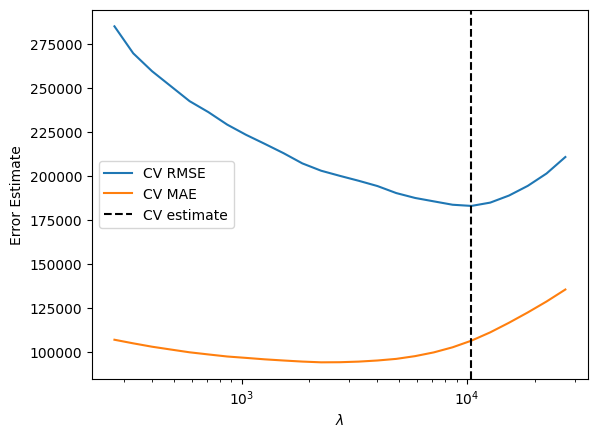

In [ ]:
# Plot the performance metrics across values of the tuning parameter
cvrmse_lasint = np.sqrt(cvmse_lasint)
lambdas = lasint.cv_results_.get('param_lasso__alpha').tolist()

# Make plot
plt.semilogx(lambdas, cvrmse_lasint, label='CV RMSE')
plt.semilogx(lambdas, cvmae_lasint, label='CV MAE')
plt.axvline(lasint.best_params_.get('lasso__alpha'),
            linestyle="--", color="black", label="CV estimate")
plt.xlabel(r"$\lambda$")
plt.ylabel("Error Estimate")
plt.legend()
plt.show()

In [ ]:
# Variables in the model and estimated coefficients
intcoefs = pd.DataFrame(data={'Variable Names': X.columns[lasso_model.coef_ != 0], 'Coefficient': lasso_model.coef_[lasso_model.coef_ != 0]})
print(intcoefs.to_markdown())

|     | Variable Names                                                                 |     Coefficient |
|----:|:-------------------------------------------------------------------------------|----------------:|
|   0 | poly(sqft_living, degree=2, raw=True)[0]                                       | 127490          |
|   1 | poly(bathrooms, degree=2, raw=True)[0]:poly(view, degree=2, raw=True)[0]       |  13733.8        |
|   2 | poly(bathrooms, degree=2, raw=True)[1]:poly(condition, degree=2, raw=True)[1]  |   2398.6        |
|   3 | poly(bathrooms, degree=2, raw=True)[0]:poly(sqft_above, degree=2, raw=True)[0] |   6400.84       |
|   4 | poly(bathrooms, degree=2, raw=True)[1]:C(statezip)[T.WA 98029]                 |   5319.15       |
|   5 | poly(bathrooms, degree=2, raw=True)[1]:C(statezip)[T.WA 98033]                 |   3248.29       |
|   6 | poly(bathrooms, degree=2, raw=True)[1]:C(statezip)[T.WA 98040]                 |  11634.7        |
|   7 | poly(bathrooms, degree=2, raw

**Questions:**

1. We have a list of variables and coefficients. Is the model particularly interpretable?
2. Should we conclude we have the "correct" variables?

In [ ]:
# Let's add these results to our result table
model_results = model_results._append({'Model': 'Level Interactions Lasso',
                                       'RMSE': np.sqrt(bestmse_lasint),
                                       'R2 - MSE': 1-(bestmse_lasint/benchMSE),
                                       'MAE': bestmae_lasint,
                                       'R2 - MAE': 1-(bestmae_lasint/benchMAE),
                                       'p': p_intlasso,
                                       'p_use': p_intlasso_use}, ignore_index=True)

model_results

,Model,RMSE,R2 - MSE,MAE,R2 - MAE,p,p_use
0,Level Mean,3.683945e+05,-,2.369912e+05,-,-,-
1,Level Median,3.778466e+05,-,2.262563e+05,-,-,-
2,Log Mean,3.764651e+05,-,2.262912e+05,-,-,-
3,Log Median,3.778466e+05,-,2.262563e+05,-,-,-
4,Level Baseline LM,2.102945e+05,0.674141,1.228687e+05,0.456949,58,58
5,Log Baseline LM,3.867177e+05,-0.10195,1.167789e+05,0.483864,58,58
6,Level Zip LM,1.860710e+05,0.744888,1.038540e+05,0.54099,91,91
7,Log Zip LM,3.037570e+05,0.320129,9.533528e+04,0.57864,91,91
8,Level Both LM,1.899457e+05,0.734152,1.040275e+05,0.540223,134,134
9,Log Both LM,2.996599e+05,0.338346,9.515979e+04,0.579416,134,134


# Regression Tree

Rather than try to build all the relevant features ourselves. Let's fit a regression *tree* instead. The basic idea of a regression tree is to chop the data into rectangles based on the raw input variables and then fit a simple model - we'll just use the sample mean.

The way we'll chop things into rectangles is by making binary splits of the data. Rather than try to talk about it, it's probably easier to just some results.



First, let's augment our "raw" data with dummy variables for `city` and `statezip`.

In [ ]:
# We won't need the basement and renovation flags anymore. Let's drop them.
data_tree = data.drop(columns=['basement_flag','renovated_flag'])

In [ ]:
# Add dummies for city and statezip
data_tree = pd.get_dummies(data_tree, columns = ['city', 'statezip'])

Because we're just illustrating, we'll start by making a tree with just one split using the full data set.

In [ ]:
# Let's make our outcome variables and predictors
X = data_tree.drop(columns=['price','log_price'])
price = data_tree['price']
lprice = data_tree['log_price']

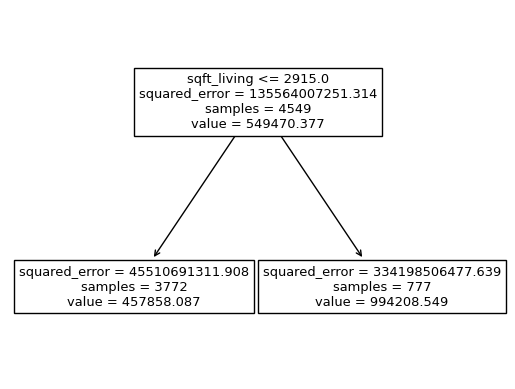

In [ ]:
# Let's fit a tree to price with 1 split = 2 leaves
tree1 = DecisionTreeRegressor(max_leaf_nodes = 2)
tree1.fit(X, price)
plot_tree(tree1, feature_names=X.columns)
plt.show()

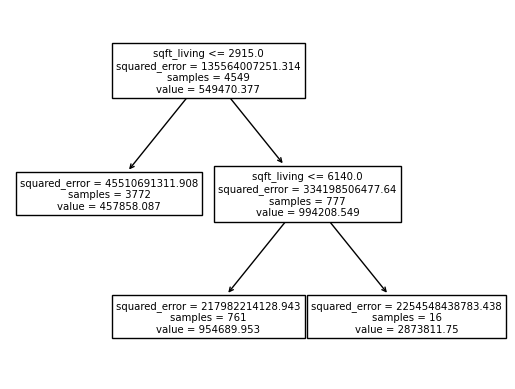

In [ ]:
# Let's fit a tree with 2 splits = 3 leaves
tree2 = DecisionTreeRegressor(max_leaf_nodes = 3)
tree2.fit(X, y)
plot_tree(tree2, feature_names=X.columns)
plt.show()

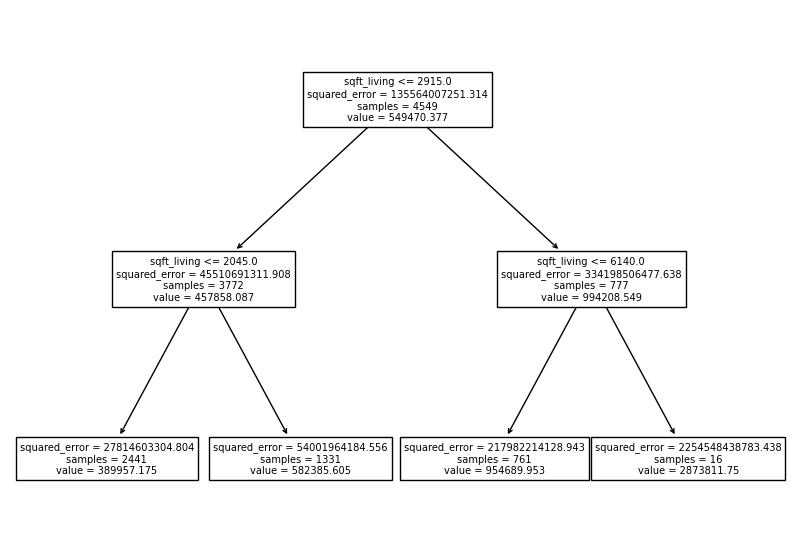

In [ ]:
# Make the figure bigger than default so it's easier to read
width = 10
height = 7
plt.figure(figsize=(width, height))

# Let's fit a tree with 3 splits = 4 leaves
tree3 = DecisionTreeRegressor(max_leaf_nodes = 4)
tree3.fit(X, y)
plot_tree(tree3, feature_names=X.columns)
plt.show()

Let's make one more plot to show how the regression tree is uncovering nonlinearity without having to prespecify transformations of the features.

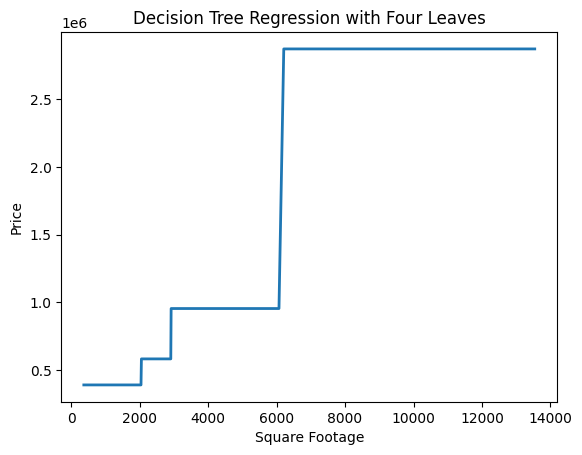

In [ ]:
# Predict
yfit = tree3.predict(X)
xplot = np.sort(X['sqft_living'])
yplot = np.sort(yfit)

# Plot
plt.figure()
plt.plot(xplot, yplot, linewidth=2)
plt.xlabel("Square Footage")
plt.ylabel("Price")
plt.title("Decision Tree Regression with Four Leaves")
plt.show()

We can (and will) continue, though we'll stop showing the picture every time. The basic idea of trees is very simple. We keep make binary splits of the data where each split improves the fit to the training data. We can fit the training data very well with enough splits - though that's unlikely to generalize well.

We choose which tree we want to use by (cross-) validation. There are lots of ways we could specify and train trees. Rather than look at number of leaves, we could look at depth. We might want to specify a minimum leaf size to avoid leaves with very few observations.

We're just going to look at cross-validating over number of leaves and not worry about other details.

In [ ]:
# Parameter we want to choose based on cross-validation performance - number of leaves
parameters = {'max_leaf_nodes':range(2,101)}

scoring = {'mse': 'neg_mean_squared_error',
           'mae': 'neg_mean_absolute_error'}

tree = DecisionTreeRegressor()
base_tree = GridSearchCV(tree, parameters, scoring = scoring, cv = cvsplit, refit = 'mse')
base_tree.fit(X, price)

GridSearchCV(cv=KFold(n_splits=5, random_state=713, shuffle=True),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_leaf_nodes': range(2, 101)}, refit='mse',
             scoring={'mae': 'neg_mean_absolute_error',
                      'mse': 'neg_mean_squared_error'})

What does our estimated tree look like?

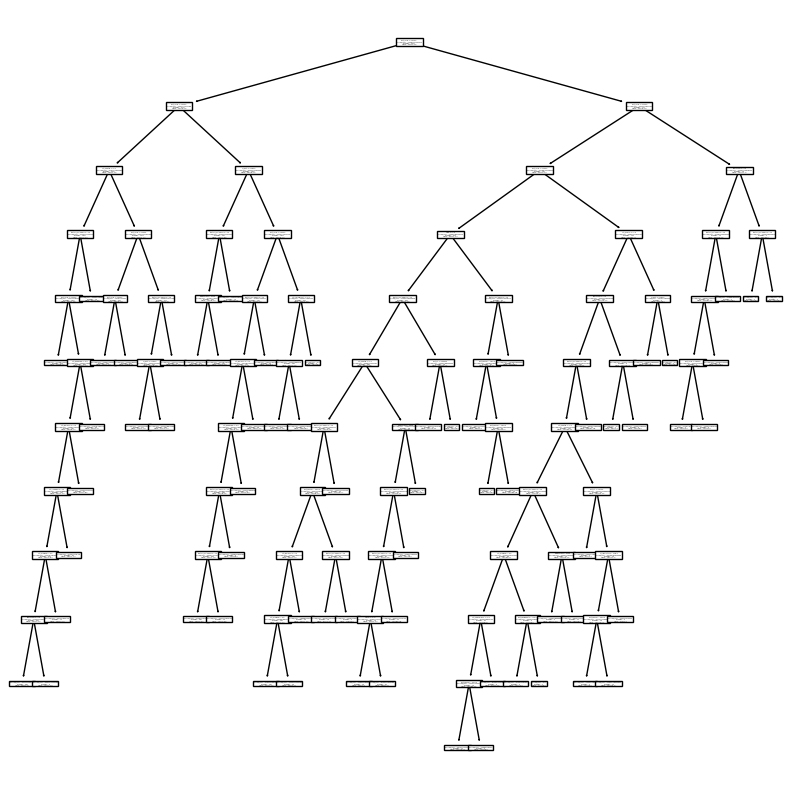

In [ ]:
width = 10
height = 10
plt.figure(figsize=(width, height))

# Let's plot the cv minimizing tree
plot_tree(base_tree.best_estimator_, feature_names=X.columns)
plt.show()

**We'd need a pretty big screen to see what's going on here.**

Let's look at cross-validation performance.

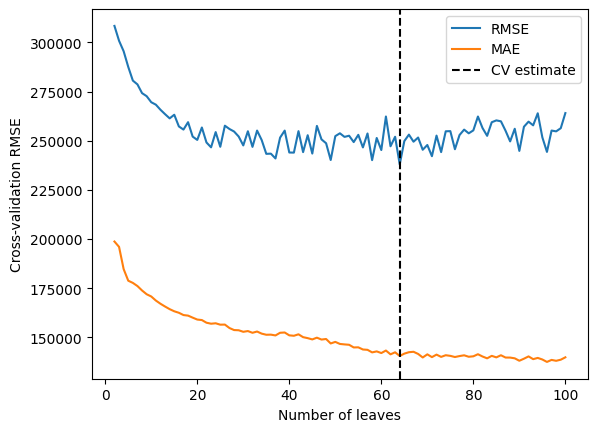

In [ ]:
leaves = base_tree.cv_results_.get('param_max_leaf_nodes')
leaves = leaves.tolist()

lranks = base_tree.cv_results_.get('rank_test_mse')
cvmse_tree = -base_tree.cv_results_.get('mean_test_mse')
cvmae_tree = -base_tree.cv_results_.get('mean_test_mae')

bestmse_base_tree = cvmse_tree[lranks == 1].min()
bestmae_base_tree = cvmae_tree[lranks == 1].min()

plt.plot(leaves, np.sqrt(cvmse_tree), label = 'RMSE')
plt.plot(leaves, cvmae_tree, label = 'MAE')
plt.axvline(base_tree.best_params_.get('max_leaf_nodes'),
            linestyle="--", color="black", label="CV estimate")
plt.xlabel("Number of leaves")
plt.ylabel("Cross-validation RMSE")
plt.legend()
plt.show()

In [ ]:
# Let's add these results to our results table
model_results = model_results._append({'Model': 'Decision Tree',
                                       'RMSE': np.sqrt(bestmse_base_tree),
                                       'R2 - MSE': 1-(bestmse_base_tree/benchMSE),
                                       'MAE': bestmae_base_tree,
                                       'R2 - MAE': 1-(bestmae_base_tree/benchMAE),
                                       'p': '-',
                                       'p_use': base_tree.best_params_.get('max_leaf_nodes')},
                                       ignore_index=True)

model_results

,Model,RMSE,R2 - MSE,MAE,R2 - MAE,p,p_use
0,Level Mean,3.683945e+05,-,2.369912e+05,-,-,-
1,Level Median,3.778466e+05,-,2.262563e+05,-,-,-
2,Log Mean,3.764651e+05,-,2.262912e+05,-,-,-
3,Log Median,3.778466e+05,-,2.262563e+05,-,-,-
4,Level Baseline LM,2.102945e+05,0.674141,1.228687e+05,0.456949,58,58
5,Log Baseline LM,3.867177e+05,-0.10195,1.167789e+05,0.483864,58,58
6,Level Zip LM,1.860710e+05,0.744888,1.038540e+05,0.54099,91,91
7,Log Zip LM,3.037570e+05,0.320129,9.533528e+04,0.57864,91,91
8,Level Both LM,1.899457e+05,0.734152,1.040275e+05,0.540223,134,134
9,Log Both LM,2.996599e+05,0.338346,9.515979e+04,0.579416,134,134


Looks like lots of results with similar performance and highly variable across number of leaves. Default behavior in the software allows for very small leaves (could just have one observation). We might want to add more stability be ruling out small leaves.

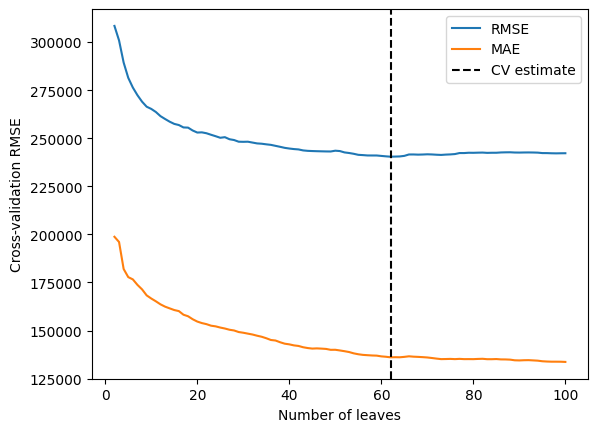

In [ ]:
# Parameter we want to choose based on cross-validation performance - number of leaves
parameters = {'max_leaf_nodes':range(2,101)}

scoring = {'mse': 'neg_mean_squared_error',
           'mae': 'neg_mean_absolute_error'}

# Let's make it so each leaf must have 10 or more observations
tree = DecisionTreeRegressor(min_samples_leaf=10)
tree10 = GridSearchCV(tree, parameters, scoring = scoring, cv = cvsplit, refit = 'mse')
tree10.fit(X, price)

leaves = tree10.cv_results_.get('param_max_leaf_nodes')
leaves = leaves.tolist()

lranks = tree10.cv_results_.get('rank_test_mse')
cvmse_tree = -tree10.cv_results_.get('mean_test_mse')
cvmae_tree = -tree10.cv_results_.get('mean_test_mae')

bestmse_tree10 = cvmse_tree[lranks == 1].min()
bestmae_tree10 = cvmae_tree[lranks == 1].min()

plt.plot(leaves, np.sqrt(cvmse_tree), label = 'RMSE')
plt.plot(leaves, cvmae_tree, label = 'MAE')
plt.axvline(tree10.best_params_.get('max_leaf_nodes'),
            linestyle="--", color="black", label="CV estimate")
plt.xlabel("Number of leaves")
plt.ylabel("Cross-validation RMSE")
plt.legend()
plt.show()

In [ ]:
# Let's add these results to our results table
model_results = model_results._append({'Model': 'Decision Tree 10',
                                       'RMSE': np.sqrt(bestmse_tree10),
                                       'R2 - MSE': 1-(bestmse_tree10/benchMSE),
                                       'MAE': bestmae_tree10,
                                       'R2 - MAE': 1-(bestmae_tree10/benchMAE),
                                       'p': '-',
                                       'p_use': tree10.best_params_.get('max_leaf_nodes')},
                                       ignore_index=True)

model_results

,Model,RMSE,R2 - MSE,MAE,R2 - MAE,p,p_use
0,Level Mean,3.683945e+05,-,2.369912e+05,-,-,-
1,Level Median,3.778466e+05,-,2.262563e+05,-,-,-
2,Log Mean,3.764651e+05,-,2.262912e+05,-,-,-
3,Log Median,3.778466e+05,-,2.262563e+05,-,-,-
4,Level Baseline LM,2.102945e+05,0.674141,1.228687e+05,0.456949,58,58
5,Log Baseline LM,3.867177e+05,-0.10195,1.167789e+05,0.483864,58,58
6,Level Zip LM,1.860710e+05,0.744888,1.038540e+05,0.54099,91,91
7,Log Zip LM,3.037570e+05,0.320129,9.533528e+04,0.57864,91,91
8,Level Both LM,1.899457e+05,0.734152,1.040275e+05,0.540223,134,134
9,Log Both LM,2.996599e+05,0.338346,9.515979e+04,0.579416,134,134


As we did before, we can also use `log_price` as dependent variable.

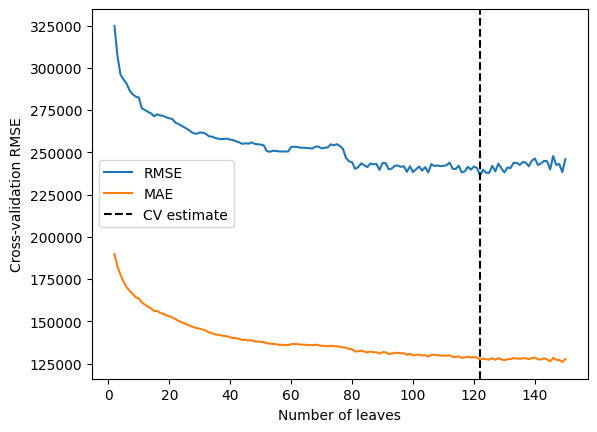

In [ ]:
# Parameter we want to choose based on cross-validation performance - number of leaves
parameters = {'max_leaf_nodes':range(2,151)}

scoring = {'expmse': expmse_score,
           'expmae': expmae_score,
           'mse': 'neg_mean_squared_error',
           'mae': 'neg_mean_absolute_error'}

tree = DecisionTreeRegressor()
log_tree = GridSearchCV(tree, parameters, scoring = scoring, cv = cvsplit, refit = 'expmse')
log_tree.fit(X, lprice)

# Plot CV performance
leaves = log_tree.cv_results_.get('param_max_leaf_nodes')
leaves = leaves.tolist()

lranks = log_tree.cv_results_.get('rank_test_expmse')
cvmse_tree = -log_tree.cv_results_.get('mean_test_expmse')
cvmae_tree = -log_tree.cv_results_.get('mean_test_expmae')

bestmse_log_tree = cvmse_tree[lranks == 1].min()
bestmae_log_tree = cvmae_tree[lranks == 1].min()

plt.plot(leaves, np.sqrt(cvmse_tree), label = 'RMSE')
plt.plot(leaves, cvmae_tree, label = 'MAE')
plt.axvline(log_tree.best_params_.get('max_leaf_nodes'),
            linestyle="--", color="black", label="CV estimate")
plt.xlabel("Number of leaves")
plt.ylabel("Cross-validation RMSE")
plt.legend()
plt.show()

In [ ]:
# Let's add these results to our results table
model_results = model_results._append({'Model': 'Decision Tree - Log',
                                       'RMSE': np.sqrt(bestmse_log_tree),
                                       'R2 - MSE': 1-(bestmse_log_tree/benchMSE),
                                       'MAE': bestmae_log_tree,
                                       'R2 - MAE': 1-(bestmae_log_tree/benchMAE),
                                       'p': '-',
                                       'p_use': log_tree.best_params_.get('max_leaf_nodes')},
                                       ignore_index=True)

model_results

,Model,RMSE,R2 - MSE,MAE,R2 - MAE,p,p_use
0,Level Mean,3.683945e+05,-,2.369912e+05,-,-,-
1,Level Median,3.778466e+05,-,2.262563e+05,-,-,-
2,Log Mean,3.764651e+05,-,2.262912e+05,-,-,-
3,Log Median,3.778466e+05,-,2.262563e+05,-,-,-
4,Level Baseline LM,2.102945e+05,0.674141,1.228687e+05,0.456949,58,58
5,Log Baseline LM,3.867177e+05,-0.10195,1.167789e+05,0.483864,58,58
6,Level Zip LM,1.860710e+05,0.744888,1.038540e+05,0.54099,91,91
7,Log Zip LM,3.037570e+05,0.320129,9.533528e+04,0.57864,91,91
8,Level Both LM,1.899457e+05,0.734152,1.040275e+05,0.540223,134,134
9,Log Both LM,2.996599e+05,0.338346,9.515979e+04,0.579416,134,134


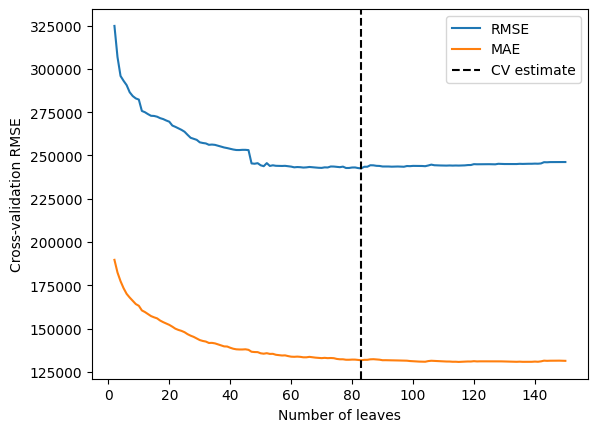

In [ ]:
# Parameter we want to choose based on cross-validation performance - number of leaves
parameters = {'max_leaf_nodes':range(2,151)}

scoring = {'expmse': expmse_score,
           'expmae': expmae_score,
           'mse': 'neg_mean_squared_error',
           'mae': 'neg_mean_absolute_error'}

tree = DecisionTreeRegressor(min_samples_leaf=10)
log_tree10 = GridSearchCV(tree, parameters, scoring = scoring, cv = cvsplit, refit = 'expmse')
log_tree10.fit(X, lprice)

# Plot CV performance
leaves = log_tree10.cv_results_.get('param_max_leaf_nodes')
leaves = leaves.tolist()

lranks = log_tree10.cv_results_.get('rank_test_expmse')
cvmse_tree = -log_tree10.cv_results_.get('mean_test_expmse')
cvmae_tree = -log_tree10.cv_results_.get('mean_test_expmae')

bestmse_log_tree10 = cvmse_tree[lranks == 1].min()
bestmae_log_tree10 = cvmae_tree[lranks == 1].min()

plt.plot(leaves, np.sqrt(cvmse_tree), label = 'RMSE')
plt.plot(leaves, cvmae_tree, label = 'MAE')
plt.axvline(log_tree10.best_params_.get('max_leaf_nodes'),
            linestyle="--", color="black", label="CV estimate")
plt.xlabel("Number of leaves")
plt.ylabel("Cross-validation RMSE")
plt.legend()
plt.show()

In [ ]:
# Let's add these results to our results table
model_results = model_results._append({'Model': 'Decision Tree10 - Log',
                                       'RMSE': np.sqrt(bestmse_log_tree10),
                                       'R2 - MSE': 1-(bestmse_log_tree10/benchMSE),
                                       'MAE': bestmae_log_tree10,
                                       'R2 - MAE': 1-(bestmae_log_tree10/benchMAE),
                                       'p': '-',
                                       'p_use': log_tree10.best_params_.get('max_leaf_nodes')},
                                       ignore_index=True)

model_results

,Model,RMSE,R2 - MSE,MAE,R2 - MAE,p,p_use
0,Level Mean,3.683945e+05,-,2.369912e+05,-,-,-
1,Level Median,3.778466e+05,-,2.262563e+05,-,-,-
2,Log Mean,3.764651e+05,-,2.262912e+05,-,-,-
3,Log Median,3.778466e+05,-,2.262563e+05,-,-,-
4,Level Baseline LM,2.102945e+05,0.674141,1.228687e+05,0.456949,58,58
5,Log Baseline LM,3.867177e+05,-0.10195,1.167789e+05,0.483864,58,58
6,Level Zip LM,1.860710e+05,0.744888,1.038540e+05,0.54099,91,91
7,Log Zip LM,3.037570e+05,0.320129,9.533528e+04,0.57864,91,91
8,Level Both LM,1.899457e+05,0.734152,1.040275e+05,0.540223,134,134
9,Log Both LM,2.996599e+05,0.338346,9.515979e+04,0.579416,134,134
